# Data Analysis

## 1. Data preparation

In [1]:
# move to project root
%cd ..
%pwd

/Users/heste/workspace/soccernet/sn-script


'/Users/heste/workspace/soccernet/sn-script'

In [3]:
import os
from dataclasses import dataclass
from pathlib import Path

import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pylab as plt_lab
from matplotlib import pyplot as plt
from tqdm import tqdm

from sn_script.config import binary_category_name
from sn_script.csv_utils import seconds_to_gametime
from sn_script.spotting.cross_label_analysis import label_ratio_around_action_camera
from sn_script.spotting.label_analysis import label_ratio_around_event
from sn_script.spotting.preprocess import preprocess_gametime

# pandasのprogress_applyを使うために必要
tqdm.pandas()

# matplotlibのデフォルトフォントをTakaoGothicに設定
font = {"family": "IPAexGothic"}
matplotlib.rc("font", **font)
plt_lab.rcParams.update({"font.size": 22})

In [4]:
@dataclass
class Config:
    csv_path = Path('database/stable/scbi-v2.csv')
    sncaption_path = Path('database/misc/soccernet_labels.csv')
    snspotting_path = Path('database/misc/soccernet_spotting_labels.csv')
    sncameras_path = Path('database/misc/soccernet_cameras.csv')

In [5]:
scbi_df = pd.read_csv(Config.csv_path)
sncaption_df = pd.read_csv(Config.sncaption_path)
spotting_df = pd.read_csv(Config.snspotting_path)
camera_df = pd.read_csv(Config.sncameras_path)

In [7]:
spotting_df = preprocess_gametime(spotting_df)
camera_df = preprocess_gametime(camera_df)

## actionとcameraの相互作用

In [6]:
pair_result_df, comment_df = label_ratio_around_action_camera(
    comment_df=scbi_df,
    action_df=spotting_df,
    camera_df=camera_df,
    window_former=0,
    window_latter=15,
    binary_category_name=binary_category_name,
)

camera label loop: 100%|██████████| 13/13 [00:04<00:00,  2.98it/s]
338023it [00:32, 10486.87it/s]

Pair ratio saved to: database/misc/label_ratio_around_action-camera_0-15.csv


In [9]:
# 付加的情報が多いペアを表示
pair_result_df[pair_result_df["count"] >= 100].sort_values(by="ratio", ascending=False).head(20)

,action_label,camera_label,count,count_additional,ratio,ratio(%)
107,Penalty,Close-up player or field referee,121,59,0.487603,48.760%
51,Goal,Close-up side staff,124,50,0.403226,40.323%
20,Goal,Main camera center,994,346,0.348089,34.809%
87,Kick-off,Main camera center,126,43,0.341270,34.127%
52,Goal,Close-up player or field referee,830,283,0.340964,34.096%
82,Kick-off,Main behind the goal,207,70,0.338164,33.816%
33,Yellow card,Main camera center,1034,337,0.325919,32.592%
83,Kick-off,Close-up behind the goal,579,186,0.321244,32.124%
21,Kick-off,Close-up player or field referee,1795,561,0.312535,31.253%
53,Kick-off,Close-up side staff,485,151,0.311340,31.134%


In [10]:
# 付加的情報が少ないペアを表示
pair_result_df[pair_result_df["count"] >= 100].sort_values(by="ratio", ascending=True).head(20)

,action_label,camera_label,count,count_additional,ratio,ratio(%)
63,Shots off target,Close-up corner,139,17,0.122302,12.230%
108,Corner,Spider camera,238,33,0.138655,13.866%
76,Corner,Main behind the goal,496,72,0.145161,14.516%
44,Throw-in,Main camera right,218,33,0.151376,15.138%
37,Corner,Main camera right,352,58,0.164773,16.477%
64,Throw-in,Close-up behind the goal,328,55,0.167683,16.768%
11,Corner,Main camera left,397,69,0.173804,17.380%
24,Corner,Close-up corner,1520,266,0.175000,17.500%
60,Throw-in,Other,588,106,0.180272,18.027%
112,Indirect free-kick,Other,426,79,0.185446,18.545%


In [11]:
comment_df.columns

Index(['orig_index', 'id', 'game', 'half', 'start', 'end', 'text', '小分類', '備考',
       '付加的情報か', 'language', 'speaker', 'src_text', 'league', 'season', 'date',
       'kickoff_time', 'home_team', 'home_score', 'away_score', 'away_team',
       'refer_Ball out of play', 'refer_Clearance', 'refer_Corner',
       'refer_Direct free-kick', 'refer_Foul', 'refer_Goal',
       'refer_Indirect free-kick', 'refer_Kick-off', 'refer_Offside',
       'refer_Penalty', 'refer_Red card', 'refer_Shots off target',
       'refer_Shots on target', 'refer_Substitution', 'refer_Throw-in',
       'refer_Yellow card', 'refer_Yellow->red card',
       'refer_Close-up behind the goal', 'refer_Close-up corner',
       'refer_Close-up player or field referee', 'refer_Close-up side staff',
       'refer_Goal line technology camera', 'refer_Inside the goal',
       'refer_Main behind the goal', 'refer_Main camera center',
       'refer_Main camera left', 'refer_Main camera right', 'refer_Other',
       'refer_Pub

## 2. Basic statistics

In [7]:
# 映像の統計情報
# 試合数
n_games = scbi_df['game'].nunique()
print(f"Number of games: {n_games}")
# 総合時間
group_per_video = scbi_df.groupby(['game', 'half'])
durations = group_per_video['end'].max() - group_per_video['start'].min()
durations.index = group_per_video['game'].first()
total_duration = durations.sum()
print(f"Total duration: {total_duration}")

Number of games: 339
Total duration: 1863010.56


In [8]:
# コメントの統計情報
# Total # of utterances
total_num_utterances = scbi_df.shape[0]
print(f"Total # of utterances: {total_num_utterances}")
# avg. # of utterances video (game, half)
avg_num_utterances_per_game = scbi_df.groupby(['game', 'half']).size().mean()
print(f"avg. # of utterances per game: {avg_num_utterances_per_game:.2f}")
# avg. # of characters per utterance
avg_chars_per_utterance = scbi_df['text'].dropna().apply(len).mean()
print(f"avg. # of characters per utterance: {avg_chars_per_utterance:.2f}")
# avg. length of an utterance (sec)
avg_chars_per_utterance = (scbi_df['end'] - scbi_df['start']).mean()
print(f"avg. length of an utterance: {avg_chars_per_utterance:.2f}")
# avg. length of silence (sec)
scbi_df['prev_end'] = scbi_df['end'].shift(1)
scbi_df['silence'] = (scbi_df['start'] - scbi_df['prev_end'])
scbi_df.loc[scbi_df['silence'] < 0, 'silence'] = None
silence_mean = scbi_df['silence'].mean(skipna=True)
print(f"avg. length of silence: {silence_mean:.2f}")


Total # of utterances: 338023
avg. # of utterances per game: 498.56
avg. # of characters per utterance: 57.19
avg. length of an utterance: 3.38
avg. length of silence: 2.14


In [9]:
scbi_df['start_gap'] = scbi_df['start'] - scbi_df['start'].shift(1)
scbi_df.loc[scbi_df['start_gap'] < 0, 'start_gap'] = None
print(f"avg. length of start_gap: {scbi_df['start_gap'].mean(skipna=True):.2f}")

avg. length of start_gap: 5.51


In [10]:
# 分析
# 全体におけるラベルの割合
print(scbi_df[binary_category_name].value_counts(normalize=True))
# ラベルの数
print(scbi_df[binary_category_name].value_counts())

付加的情報か
 0    0.814581
 1    0.185396
 2    0.000018
-1    0.000006
Name: proportion, dtype: float64
付加的情報か
 0    275347
 1     62668
 2         6
-1         2
Name: count, dtype: int64


In [11]:
# 分析
# 全体におけるラベルの割合
def analyze_label_ratio(df: pd.DataFrame):
    df = df.copy()
    df['prev_end'] = df['end'].shift(1)
    df['silence'] = (df['start'] - df['prev_end'])
    df.loc[df['silence'] <= 0, 'silence'] = None
    # 1秒以上のみ抽出
    df = df[df['silence'] > 1]

    print(df[binary_category_name].value_counts(normalize=True))
    # ラベルの数
    print(df[binary_category_name].value_counts())

analyze_label_ratio(scbi_df)


付加的情報か
 0    0.799889
 1    0.200070
 2    0.000033
-1    0.000008
Name: proportion, dtype: float64
付加的情報か
 0    98152
 1    24550
 2        4
-1        1
Name: count, dtype: int64


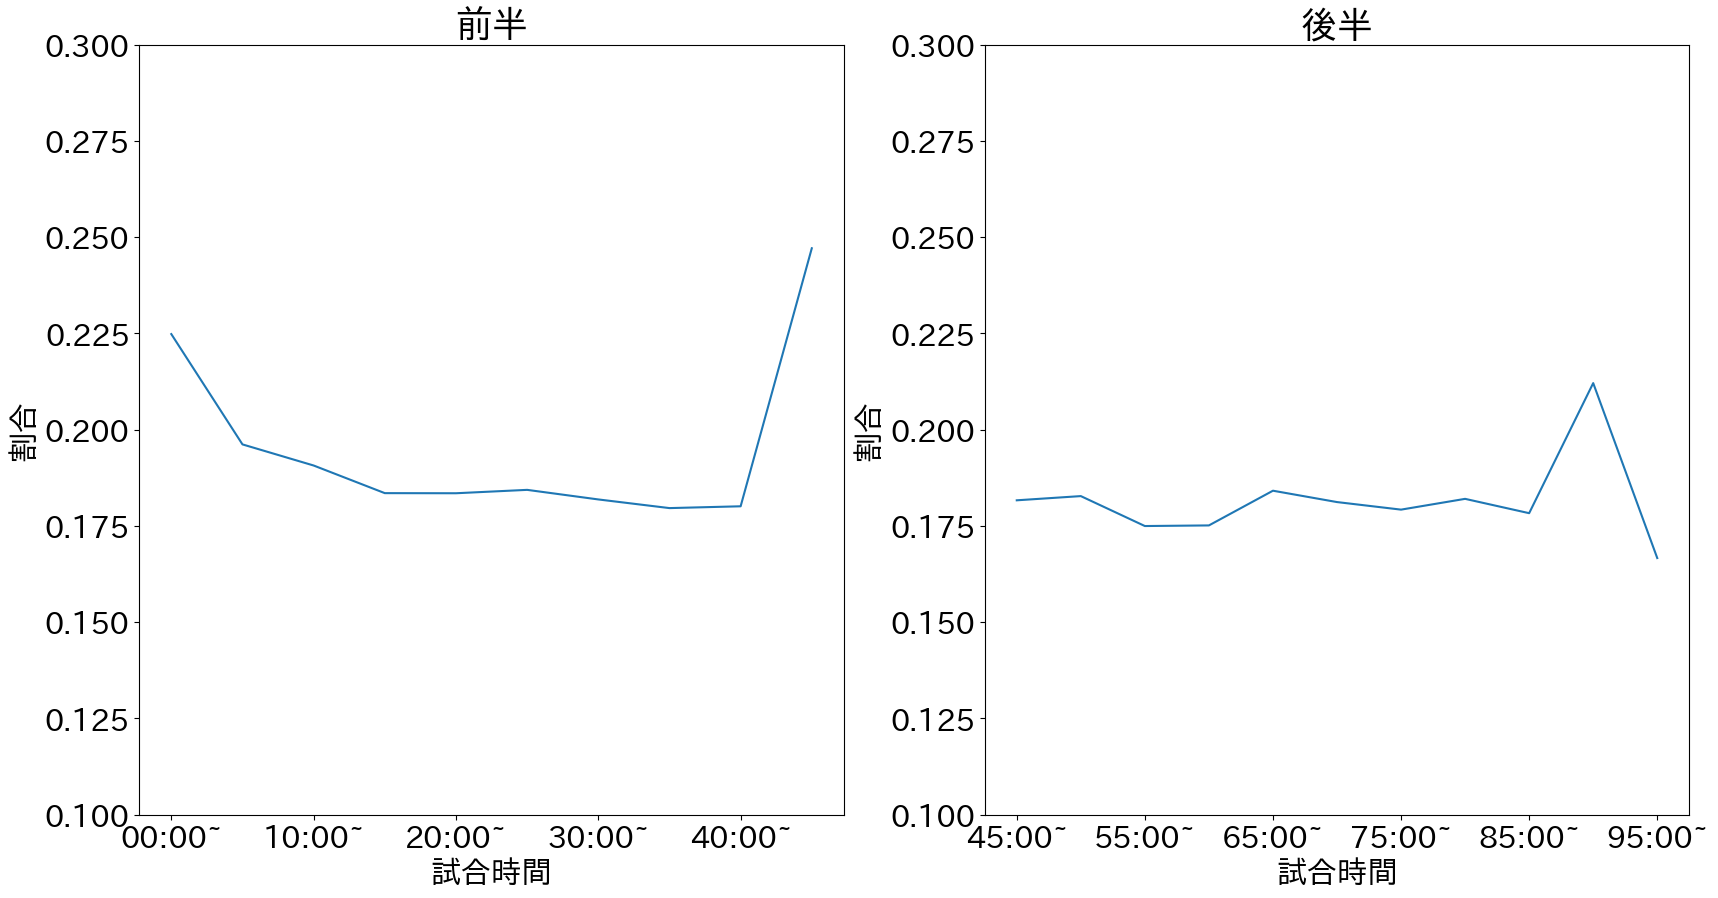

In [7]:
# 増加タイミングの分析1
# 時間帯(5分でbinning)ごとのラベルの割合
def plot_label_ratio_by_time(df: pd.DataFrame):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    df["start_bin"] = (
        df["start"] // 300
    )

    df_half_1 = df.loc[df["half"] == 1]
    piv_1_df = df_half_1.pivot_table(
        index="start_bin", columns=binary_category_name, aggfunc="count", values="text"
    )
    piv_1_df.index = [seconds_to_gametime(i * 300) + "~" for i in piv_1_df.index]
    (piv_1_df[1.0] / piv_1_df.sum(axis=1)).plot(
        xlabel="試合時間",
        ylabel="割合",
        title="前半",
        ylim=(0.1, 0.30),
        ax=ax[0]
    )
    # 後半
    half_offset = 2700
    df_half_2 = df.loc[df["half"] == 2]

    piv_2_df = df_half_2.pivot_table(
        index="start_bin", columns=binary_category_name, aggfunc="count", values="text"
    )
    piv_2_df.index = [seconds_to_gametime(i * 300 + half_offset) + "~" for i in piv_2_df.index]
    (piv_2_df[1.0] / piv_2_df.sum(axis=1)).plot(
        xlabel="試合時間",
        ylabel="割合",
        title="後半",
        ylim=(0.1, 0.30),
        ax=ax[1]
    )
    # 保存
    fig.savefig("database/images/scbi_v2-label_ratio_by_time.png")

plot_label_ratio_by_time(scbi_df)

In [70]:
# タイムスタンプ前
label_ratio_around_event(scbi_df, spotting_df, 15, 0)
# オレオレパワー実装(各コメントごとに検索):30m -> o1が生成(座圧+いもす法):7.5s

action label loop: 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]


,label,refer_count,additional_info_refer_count,ratio
0,Ball out of play,60362,9243,15.313%
1,Clearance,13416,3120,23.256%
2,Corner,8035,1864,23.199%
3,Direct free-kick,3095,680,21.971%
4,Foul,21607,3554,16.448%
5,Goal,3684,530,14.387%
6,Indirect free-kick,17473,4203,24.054%
7,Kick-off,3094,842,27.214%
8,Offside,4125,684,16.582%
9,Penalty,316,108,34.177%


In [71]:
# タイムスタンプ後
label_ratio_around_event(scbi_df, spotting_df, 0, 15)

action label loop: 100%|██████████| 17/17 [00:07<00:00,  2.40it/s]


,label,refer_count,additional_info_refer_count,ratio
0,Ball out of play,54329,11590,21.333%
1,Clearance,13003,2715,20.880%
2,Corner,10104,1719,17.013%
3,Direct free-kick,4180,784,18.756%
4,Foul,20914,5105,24.409%
5,Goal,3319,1064,32.058%
6,Indirect free-kick,18762,3482,18.559%
7,Kick-off,4784,1294,27.048%
8,Offside,3917,1053,26.883%
9,Penalty,315,145,46.032%


In [72]:
# タイムスタンプ周辺
label_ratio_around_event(scbi_df, spotting_df, 15, 15)

action label loop: 100%|██████████| 17/17 [00:07<00:00,  2.38it/s]


,label,refer_count,additional_info_refer_count,ratio
0,Ball out of play,109148,19633,17.988%
1,Clearance,26367,5822,22.081%
2,Corner,17881,3520,19.686%
3,Direct free-kick,7272,1462,20.105%
4,Foul,42087,8581,20.389%
5,Goal,6999,1594,22.775%
6,Indirect free-kick,35661,7541,21.146%
7,Kick-off,7877,2136,27.117%
8,Offside,8028,1730,21.550%
9,Penalty,631,253,40.095%


In [73]:
label_ratio_around_event(scbi_df, spotting_df, 0, 10)

action label loop: 100%|██████████| 17/17 [00:07<00:00,  2.29it/s]


,label,refer_count,additional_info_refer_count,ratio
0,Ball out of play,36812,7912,21.493%
1,Clearance,8394,1888,22.492%
2,Corner,7036,1172,16.657%
3,Direct free-kick,2994,527,17.602%
4,Foul,14306,3509,24.528%
5,Goal,2253,698,30.981%
6,Indirect free-kick,12285,2397,19.512%
7,Kick-off,3383,896,26.485%
8,Offside,2698,747,27.687%
9,Penalty,212,99,46.698%


In [74]:
label_ratio_around_event(scbi_df, spotting_df, 10, 0)

action label loop: 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]


,label,refer_count,additional_info_refer_count,ratio
0,Ball out of play,41784,6116,14.637%
1,Clearance,8627,2111,24.470%
2,Corner,5255,1190,22.645%
3,Direct free-kick,2103,432,20.542%
4,Foul,14653,2333,15.922%
5,Goal,2670,352,13.184%
6,Indirect free-kick,11450,2816,24.594%
7,Kick-off,2058,558,27.114%
8,Offside,2801,470,16.780%
9,Penalty,217,80,36.866%


In [13]:
# 増加タイミングの分析3
# 沈黙時間とラベルの割合の関係
def label_ratio_by_silence(df: pd.DataFrame):
    # intervalカラムを追加
    df["prev_end"] = df["end"].shift(1)
    df["interval"] = df["start"] - df["prev_end"]
    df.loc[df["interval"] < 0, "interval"] = None

    # 文字の長さを確認
    df['word_count'] = df['text'].str.split().str.len()


    # インターバルが30秒以上のものを表示
    for interval_length in [0.01, 0.1, 0.5, 1, 2, 4, 10, 20, 30, 40, 50, 60]:
        df[f"interval_over_{interval_length}"] = (
            df["interval"] > interval_length
        )
        total_num = len(df)
        interval_num = len(df[df[f"interval_over_{interval_length}"] == 1])
        total_bi_num = len(df[df[binary_category_name] == 1])
        interval_bi_num = len(df[(df[f"interval_over_{interval_length}"] == 1) & (df[binary_category_name] == 1)])
        # 全コメント　interval_length秒以上の沈黙の後の発話割合
        rate1 = interval_num / total_num

        # 付加的情報のみのコメント　interval_length秒以上の沈黙の後の発話割合
        rate2 = interval_bi_num / total_bi_num

        # interval_lengt秒以上の沈黙があるときの付加的情報の割合
        rate3 = interval_bi_num / interval_num

        print(
            f"全コメント{interval_length}秒インターバル後の発話数:{interval_num}\n付加的情報のみの{interval_length}秒インターバル後の発話数:{interval_bi_num}"
        )

        print(f"{interval_length}秒以上の沈黙の後の発話割合: {rate1:%}\n 付加的情報のみ,{interval_length}秒以上の沈黙の後の発話割合: {rate2:%}")
        print(f"{interval_length}秒以上の沈黙があるときの付加的情報の割合: {rate3:%}")
        # word_countの平均
        avg_word_count = df.loc[
            df[f"interval_over_{interval_length}"] == True, # noqa
            'word_count'
        ].mean()
        print(f"word_countの平均: {avg_word_count}")

label_ratio_by_silence(scbi_df)

# scbi-v1と真逆だった最悪

全コメント0.01秒インターバル後の発話数:337066
付加的情報のみの0.01秒インターバル後の発話数:62481
0.01秒以上の沈黙の後の発話割合: 99.716883%
 付加的情報のみ,0.01秒以上の沈黙の後の発話割合: 99.701602%
0.01秒以上の沈黙があるときの付加的情報の割合: 18.536726%
word_countの平均: 10.526220384138417
全コメント0.1秒インターバル後の発話数:180347
付加的情報のみの0.1秒インターバル後の発話数:35473
0.1秒以上の沈黙の後の発話割合: 53.353470%
 付加的情報のみ,0.1秒以上の沈黙の後の発話割合: 56.604647%
0.1秒以上の沈黙があるときの付加的情報の割合: 19.669304%
word_countの平均: 12.244462064797307
全コメント0.5秒インターバル後の発話数:149323
付加的情報のみの0.5秒インターバル後の発話数:29821
0.5秒以上の沈黙の後の発話割合: 44.175396%
 付加的情報のみ,0.5秒以上の沈黙の後の発話割合: 47.585690%
0.5秒以上の沈黙があるときの付加的情報の割合: 19.970802%
word_countの平均: 12.763740348104445
全コメント1秒インターバル後の発話数:122707
付加的情報のみの1秒インターバル後の発話数:24550
1秒以上の沈黙の後の発話割合: 36.301376%
 付加的情報のみ,1秒以上の沈黙の後の発話割合: 39.174698%
1秒以上の沈黙があるときの付加的情報の割合: 20.007009%
word_countの平均: 12.876844841777567
全コメント2秒インターバル後の発話数:85540
付加的情報のみの2秒インターバル後の発話数:16974
2秒以上の沈黙の後の発話割合: 25.305970%
 付加的情報のみ,2秒以上の沈黙の後の発話割合: 27.085594%
2秒以上の沈黙があるときの付加的情報の割合: 19.843348%
word_countの平均: 12.792179097498247
全コメント4秒インターバル後の発話数:53222
付加的情報のみの4秒インターバル

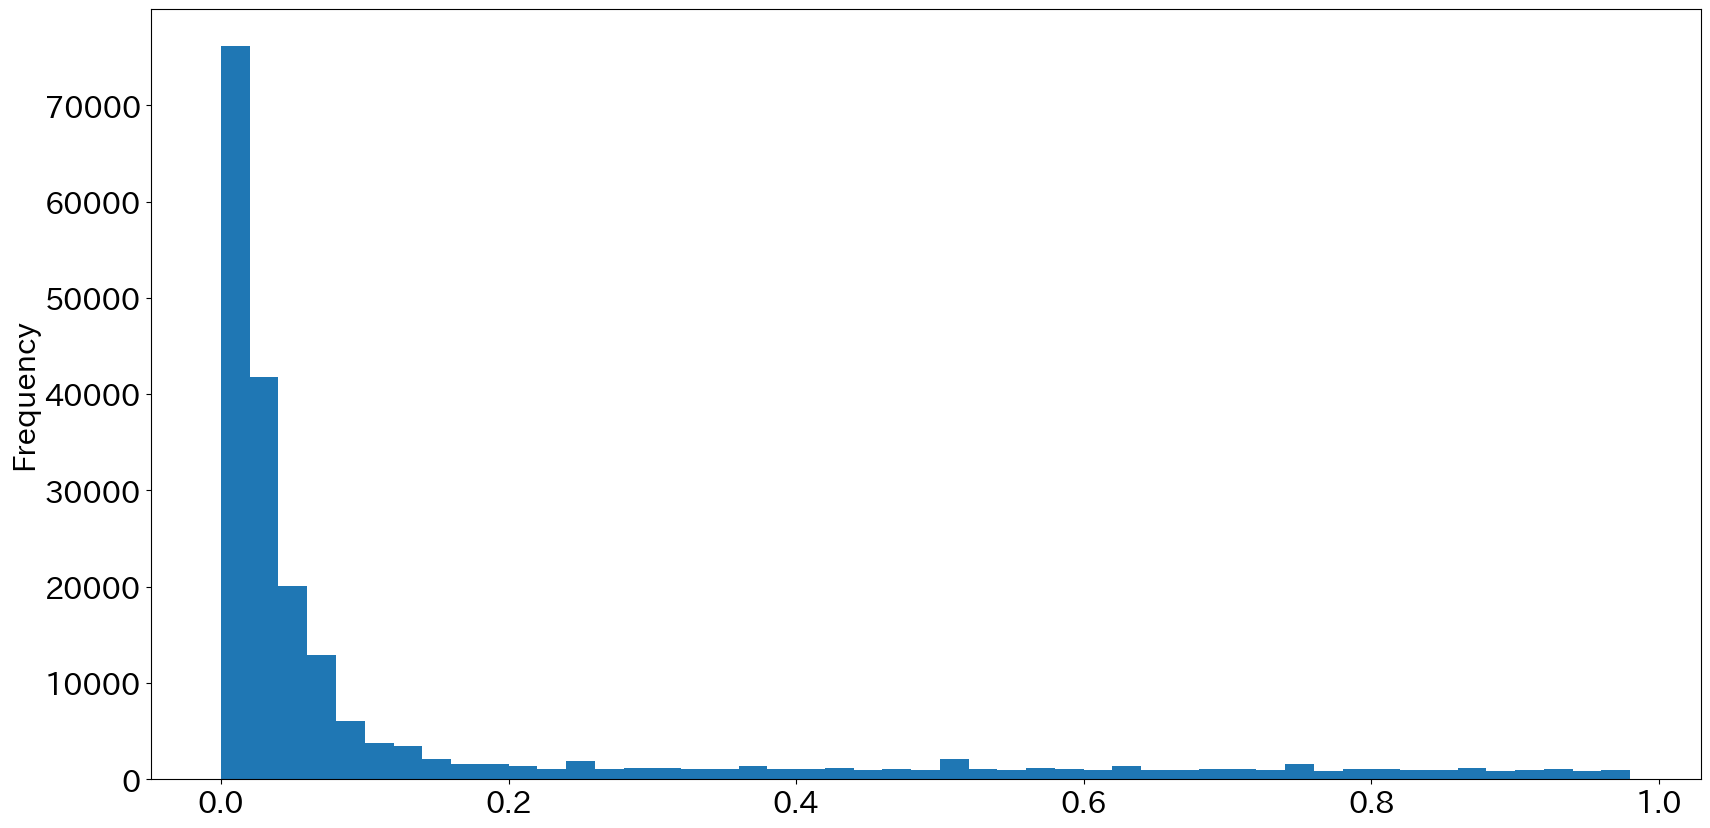

In [14]:
# 沈黙時間の分布
def plot_silence_distribution(df: pd.DataFrame):
    fig = plt.figure(figsize=(20, 10))
    df['prev_end'] = df['end'].shift(1)
    df['silence'] = (df['start'] - df['prev_end'])
    df.loc[df['silence'] <= 0, 'silence'] = None
    df['silence'].plot.hist(bins=np.arange(0, 1, 0.02), figsize=(20, 10))
    fig.savefig("database/images/scbi_v2-silence_distribution.png")

plot_silence_distribution(scbi_df)

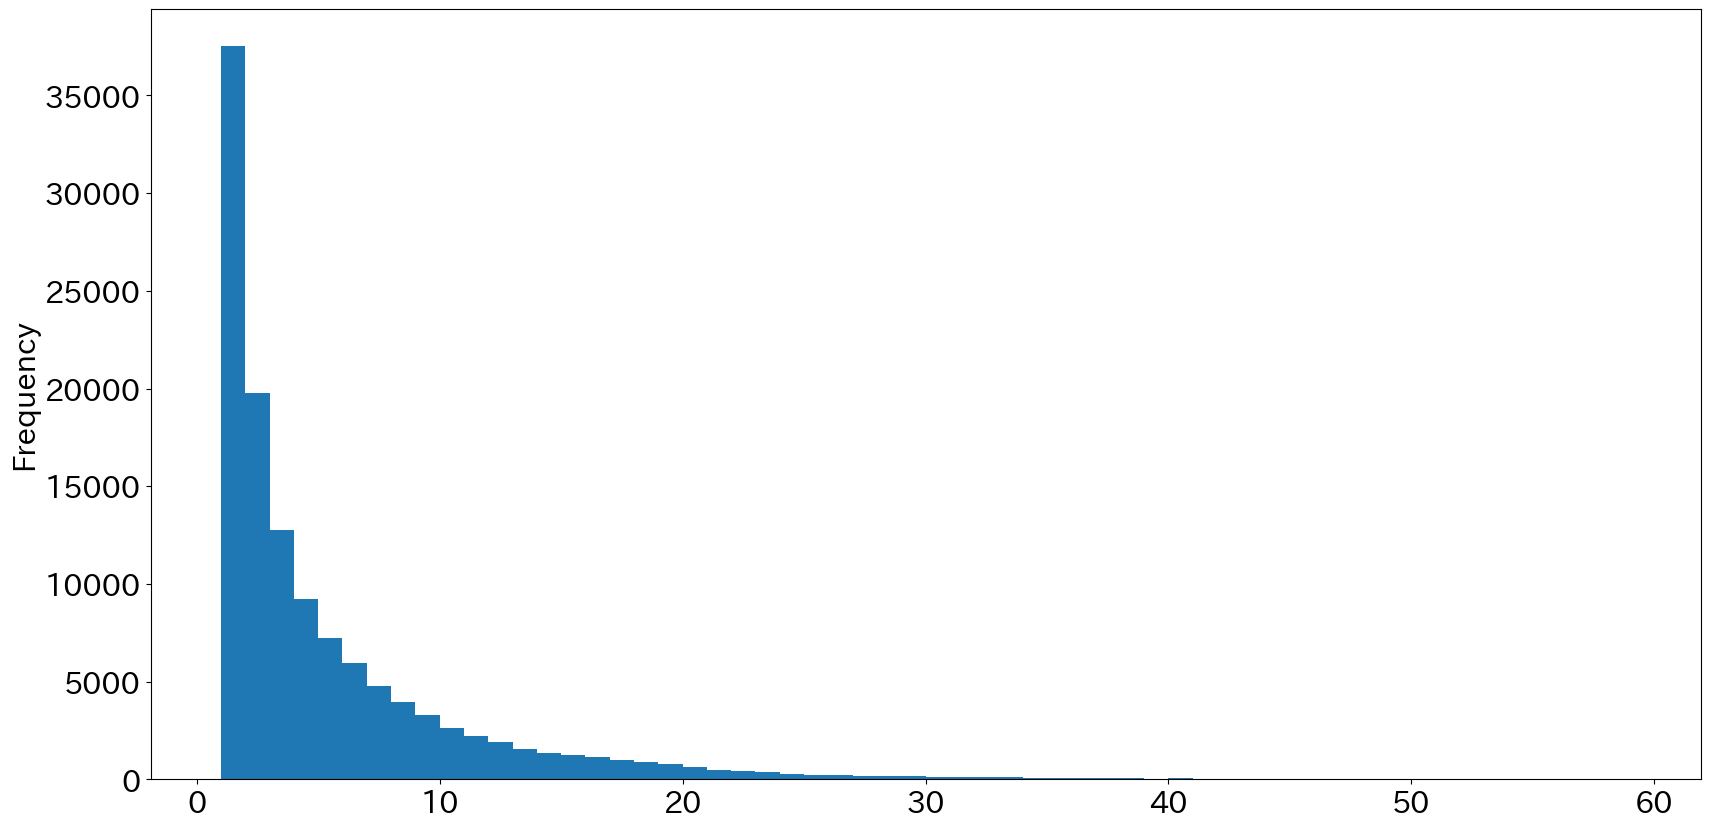

In [13]:
# 1秒以上の沈黙時間の分布
def plot_silence_distribution_over_1sec(df: pd.DataFrame):
    fig = plt.figure(figsize=(20, 10))
    df["prev_end"] = df["end"].shift(1)
    df["silence"] = df["start"] - df["prev_end"]
    df.loc[df["silence"] <= 0, "silence"] = None
    df["silence"].plot.hist(bins=np.arange(1, 60, 1), figsize=(20, 10))
    fig.savefig("database/images/scbi_v2-silence_distribution_over_1sec.png")

    # bins=np.arange(1, 60, 1) でビニングして，その分布をcsvに保存
    df["duration"] = df["silence"]
    duration_bin = df[df["duration"] > 1]["duration"]
    duration_bin = duration_bin.dropna().astype(int)

    vc_df = duration_bin.value_counts(normalize=True).sort_index()

    # silence は duration, value_counts(normalize) は p にカラム名を変更
    vc_df.name = "p"
    vc_df.to_csv("database/misc/silence_distribution_over_1sec.csv")


plot_silence_distribution_over_1sec(scbi_df)

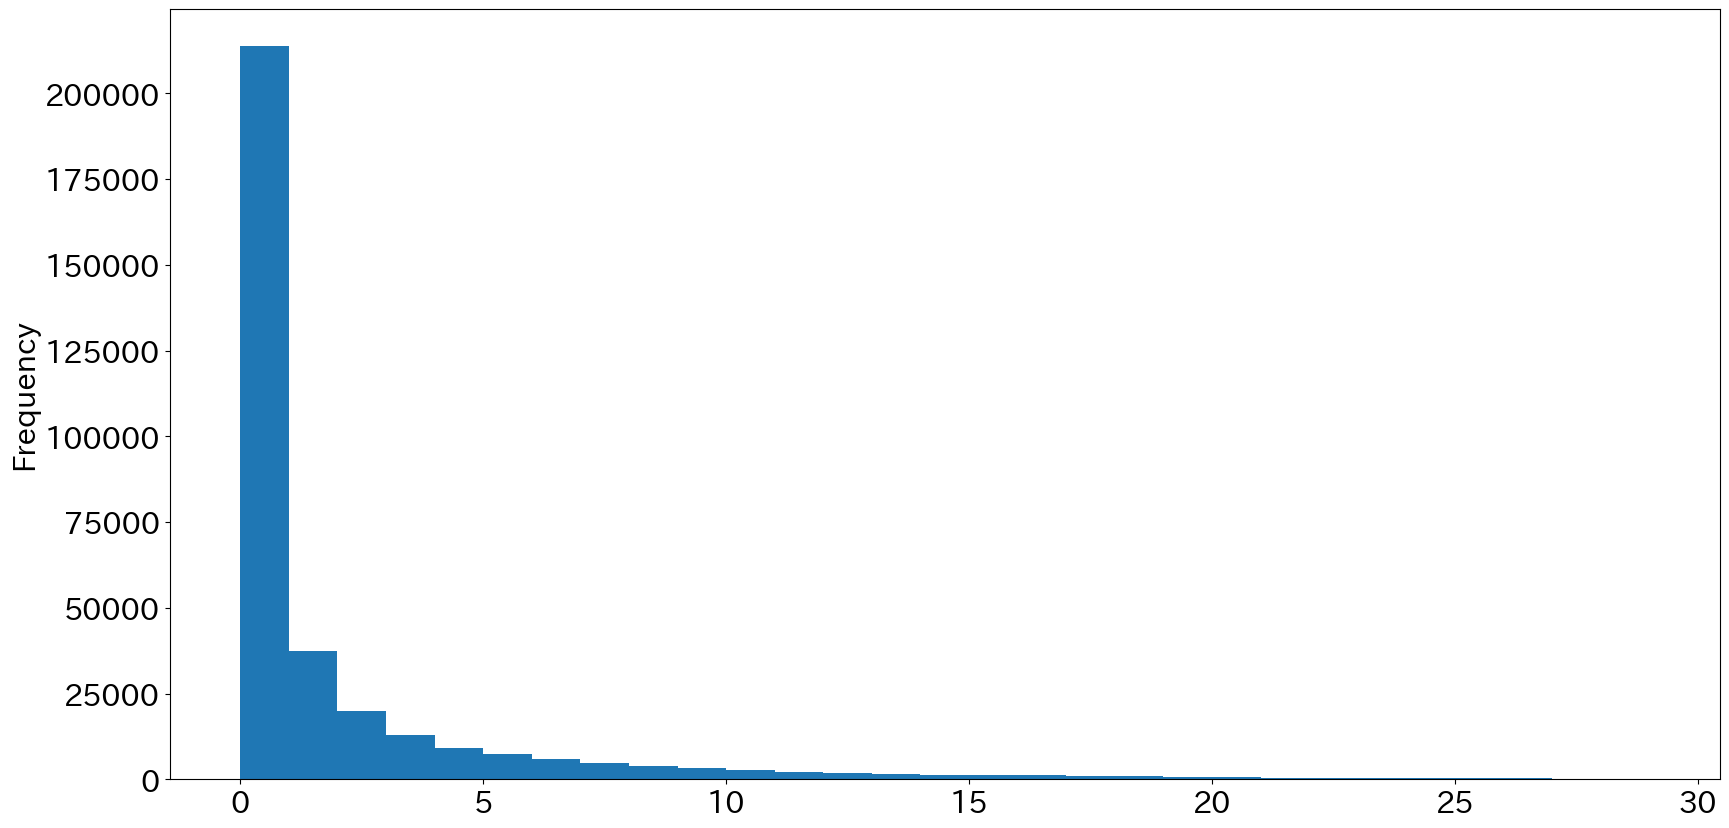

In [16]:
# 沈黙時間の分布
def plot_silence_distribution(df: pd.DataFrame):
    fig = plt.figure(figsize=(20, 10))
    df["prev_end"] = df["end"].shift(1)
    df["silence"] = df["start"] - df["prev_end"]
    df.loc[df["silence"] <= 0, "silence"] = None

    df["silence"].plot.hist(bins=np.arange(0, 30, 1), figsize=(20, 10))
    fig.savefig("database/images/scbi_v2-silence_distribution.png")

    # csvに保存
    # indexは，各binの中点をおきたい(0~1なら0.5, 1~2なら1.5)
    df["duration"] = df["silence"]

    duration_bin = ((df["duration"] // 1) + 0.5).copy()
    duration_bin = duration_bin.dropna().astype(float)
    vc_df = duration_bin.value_counts(normalize=True).sort_index()
    vc_df.name = "p"
    vc_df.to_csv("database/misc/silence_distribution.csv")


plot_silence_distribution(scbi_df)

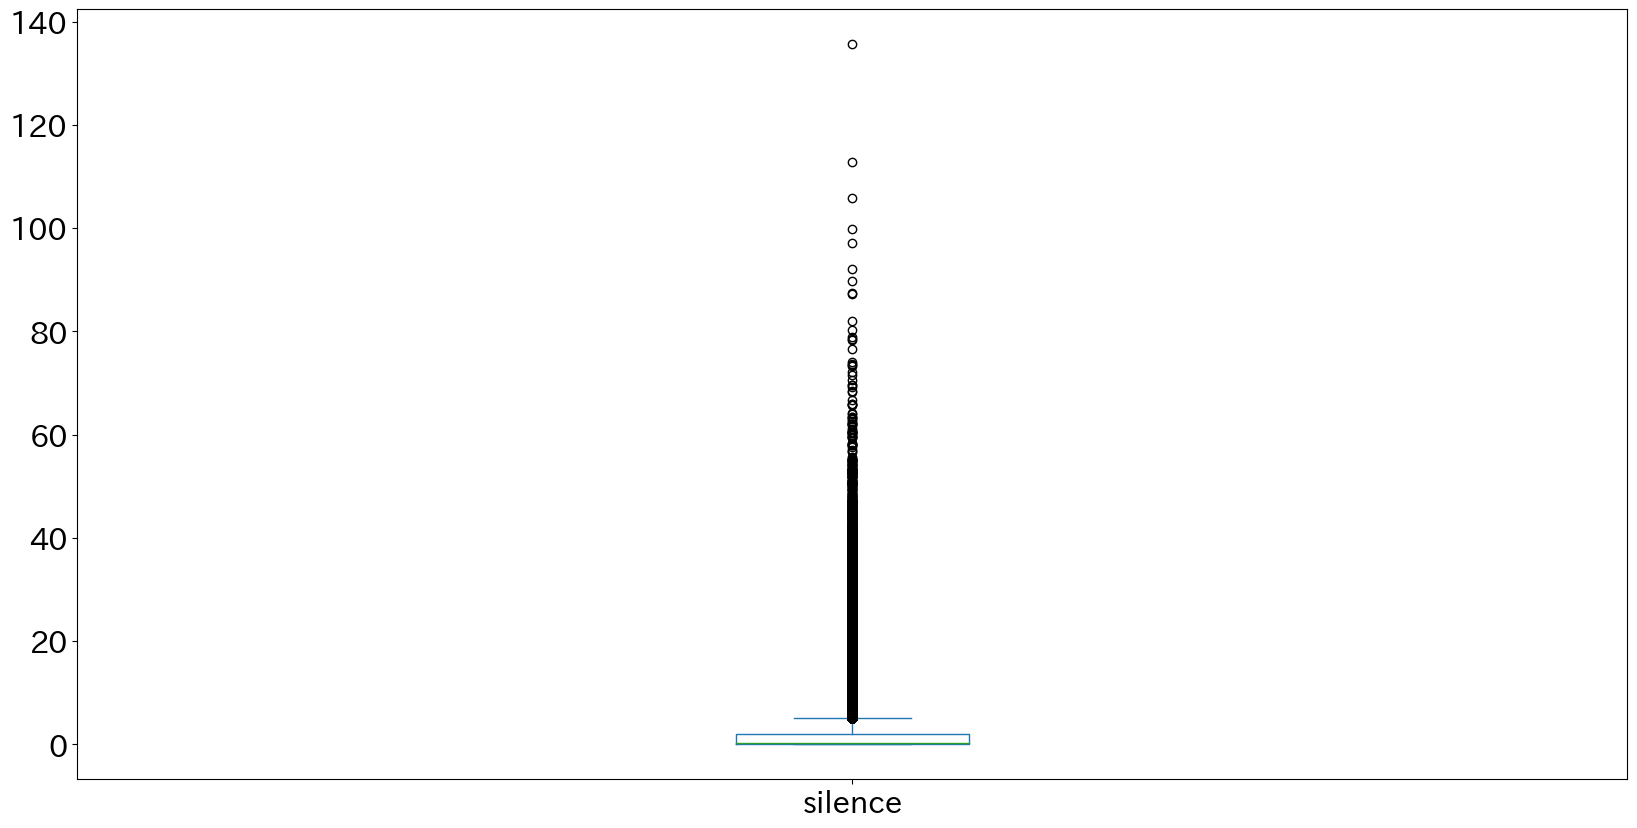

In [16]:
# 沈黙時間の箱ひげ図
def plot_silence_boxplot(df: pd.DataFrame):
    fig = plt.figure(figsize=(20, 10))
    df['prev_end'] = df['end'].shift(1)
    df['silence'] = (df['start'] - df['prev_end'])
    df.loc[df['silence'] <= 0, 'silence'] = None
    df['silence'].plot.box(figsize=(20, 10))
    fig.savefig("database/images/scbi_v2-silence_boxplot.png")

plot_silence_boxplot(scbi_df)

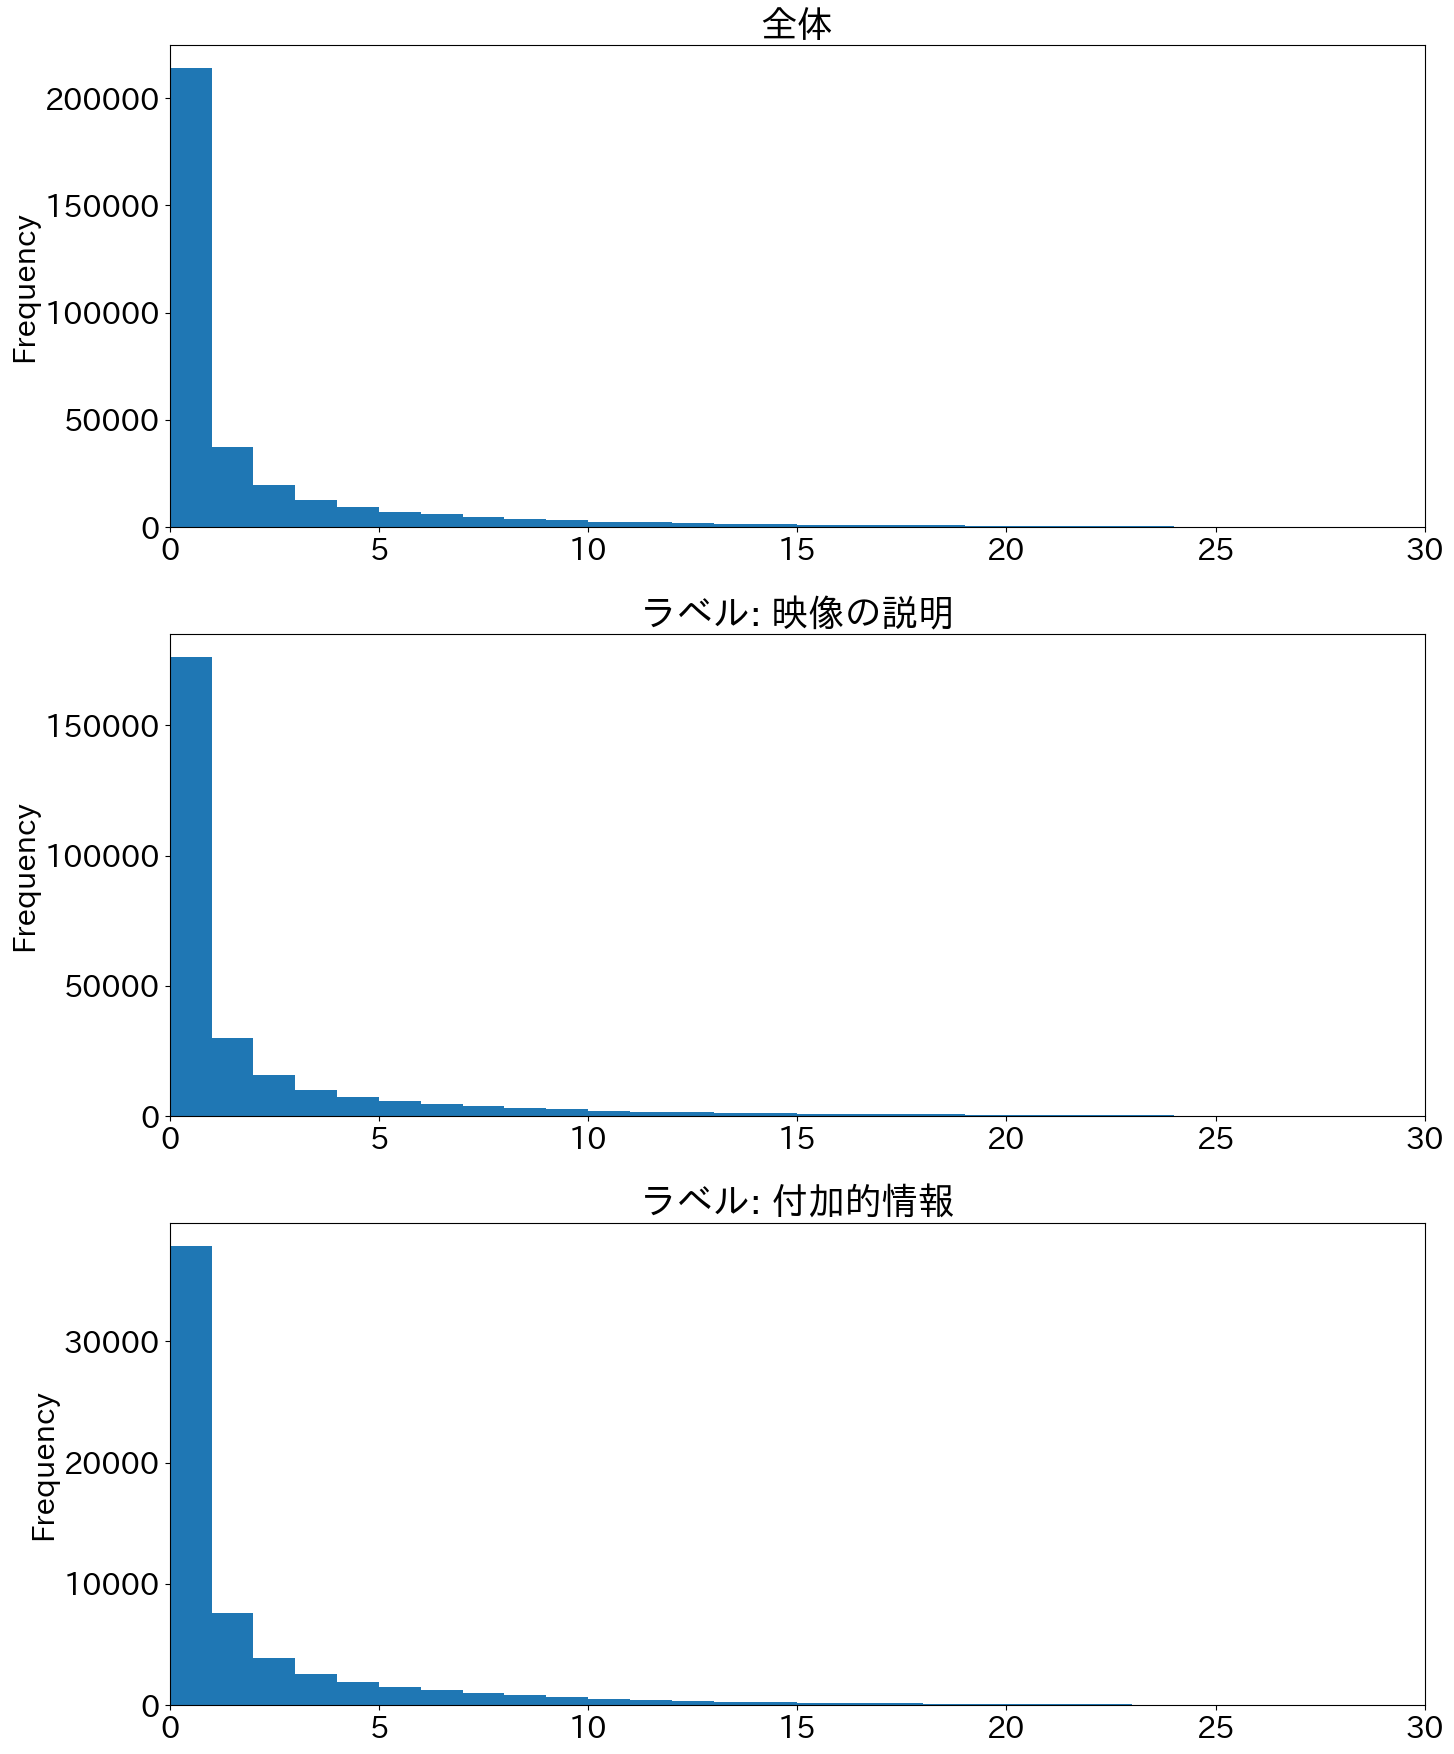

In [8]:
# 沈黙時間の分布 全体 + ラベルごとに
from sn_script.config import binary_category_name


def plot_silence_distribution(df: pd.DataFrame, ignore_under_1sec=False):
    df = df.copy()
    fig, ax = plt.subplots(3, 1, figsize=(15, 18))
    df["prev_end"] = df["end"].shift(1)
    df["silence"] = df["start"] - df["prev_end"]
    df.loc[df["silence"] <= 0, "silence"] = None
    liminf = 0
    if ignore_under_1sec:
        liminf = 1
        df = df[df["silence"] >= 1]

    # 全体
    (df.loc[:, "silence"].plot.hist(bins=np.arange(0, 60), ax=ax[0], title="全体", xlim=(liminf, 30)))

    # ラベル: 映像の説明
    (
        df.loc[df[binary_category_name] == 0, "silence"].plot.hist(
            bins=np.arange(0, 60), ax=ax[1], title="ラベル: 映像の説明", xlim=(liminf, 30)
        )
    )

    # ラベル: 付加的情報
    (
        df.loc[df[binary_category_name] == 1, "silence"].plot.hist(
            bins=np.arange(0, 60), ax=ax[2], title="ラベル: 付加的情報", xlim=(liminf, 30)
        )
    )
    fig.tight_layout()

    fig.savefig("database/images/scbi_v2-silence_distribution_group.png")


plot_silence_distribution(scbi_df)

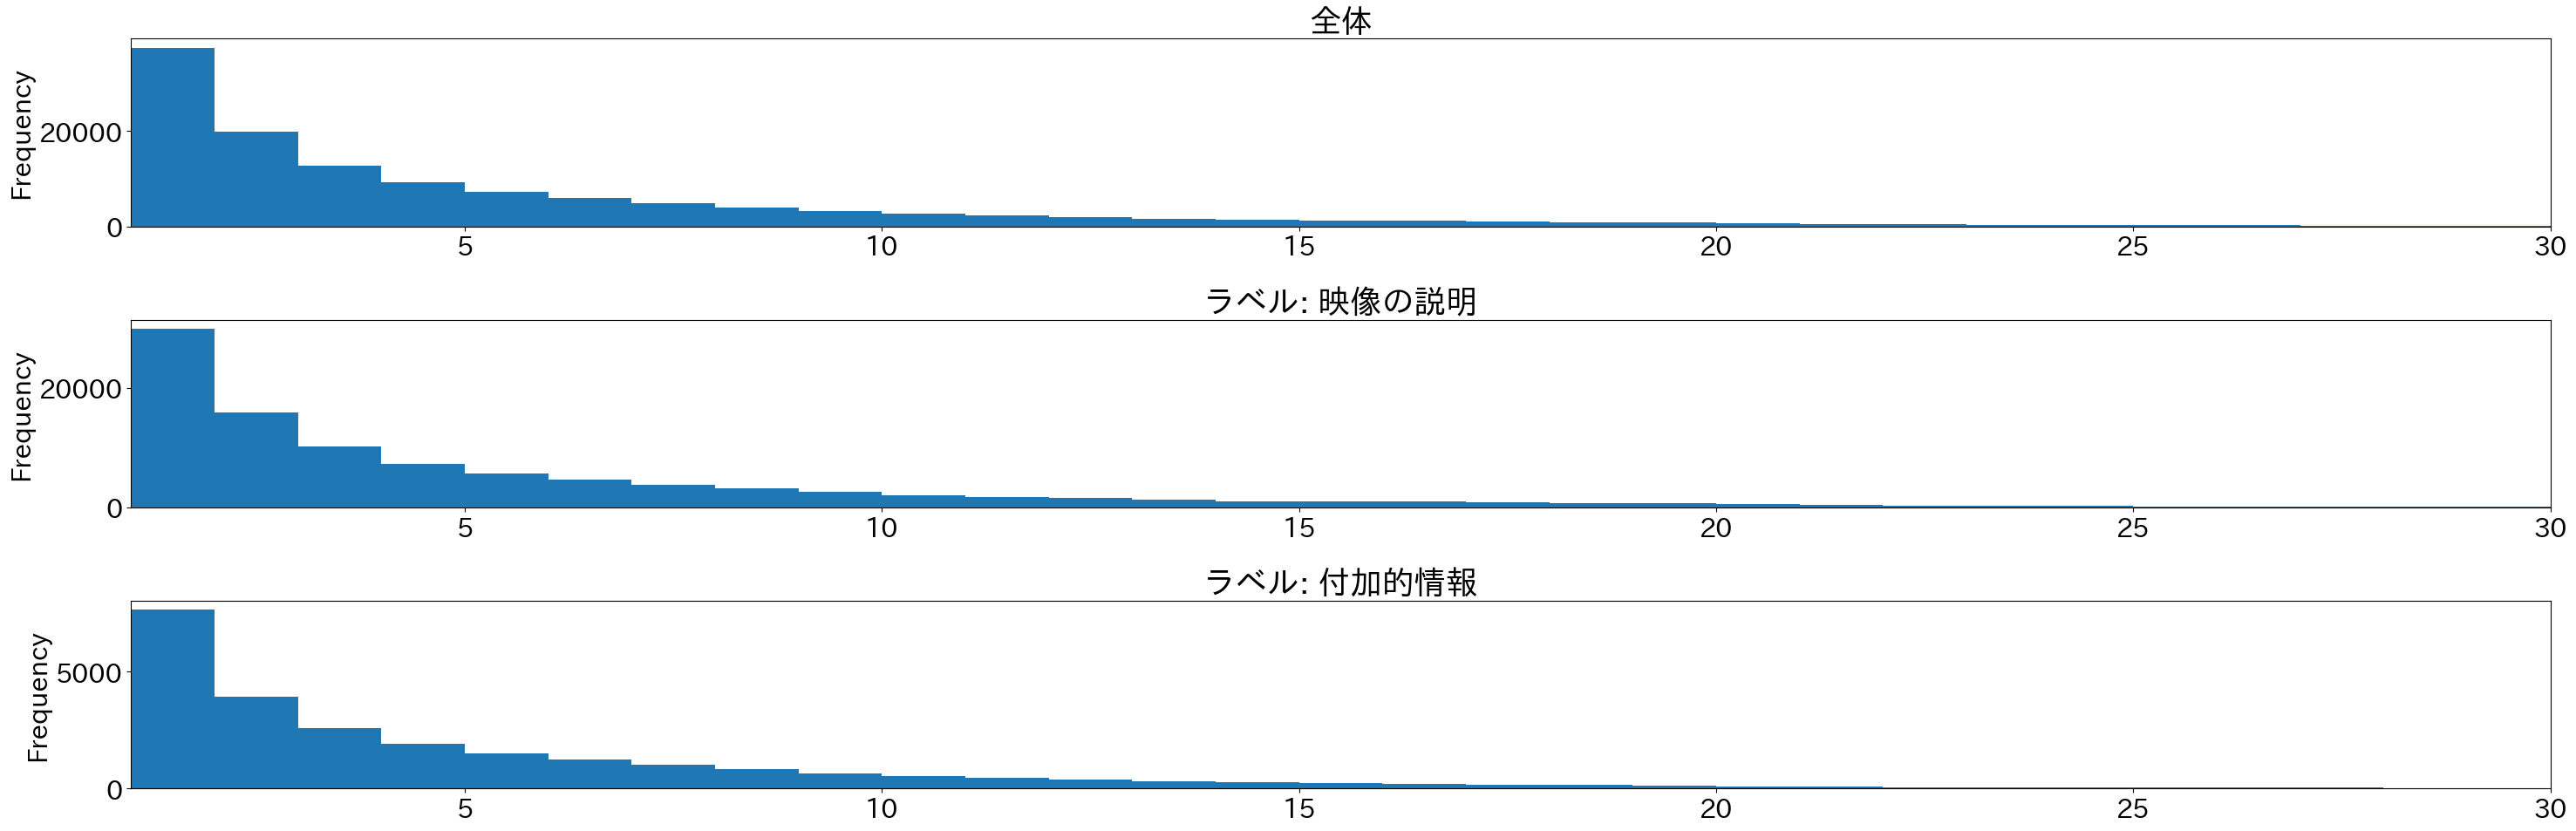

In [35]:
# 沈黙時間の分布 ラベルごとに 1秒以上
plot_silence_distribution(scbi_df, ignore_under_1sec=True)

In [13]:
#データの品質チェック
# オーバーラップの確認
def overlap_check(df: pd.DataFrame):
    df['overlap'] = df["prev_end"] - df["start"]
    rate = len(df[df['overlap'] > 0]) / len(df)
    print(f"Overlapping rate: {rate:.2f}")

overlap_check(scbi_df)

Overlapping rate: 0.00


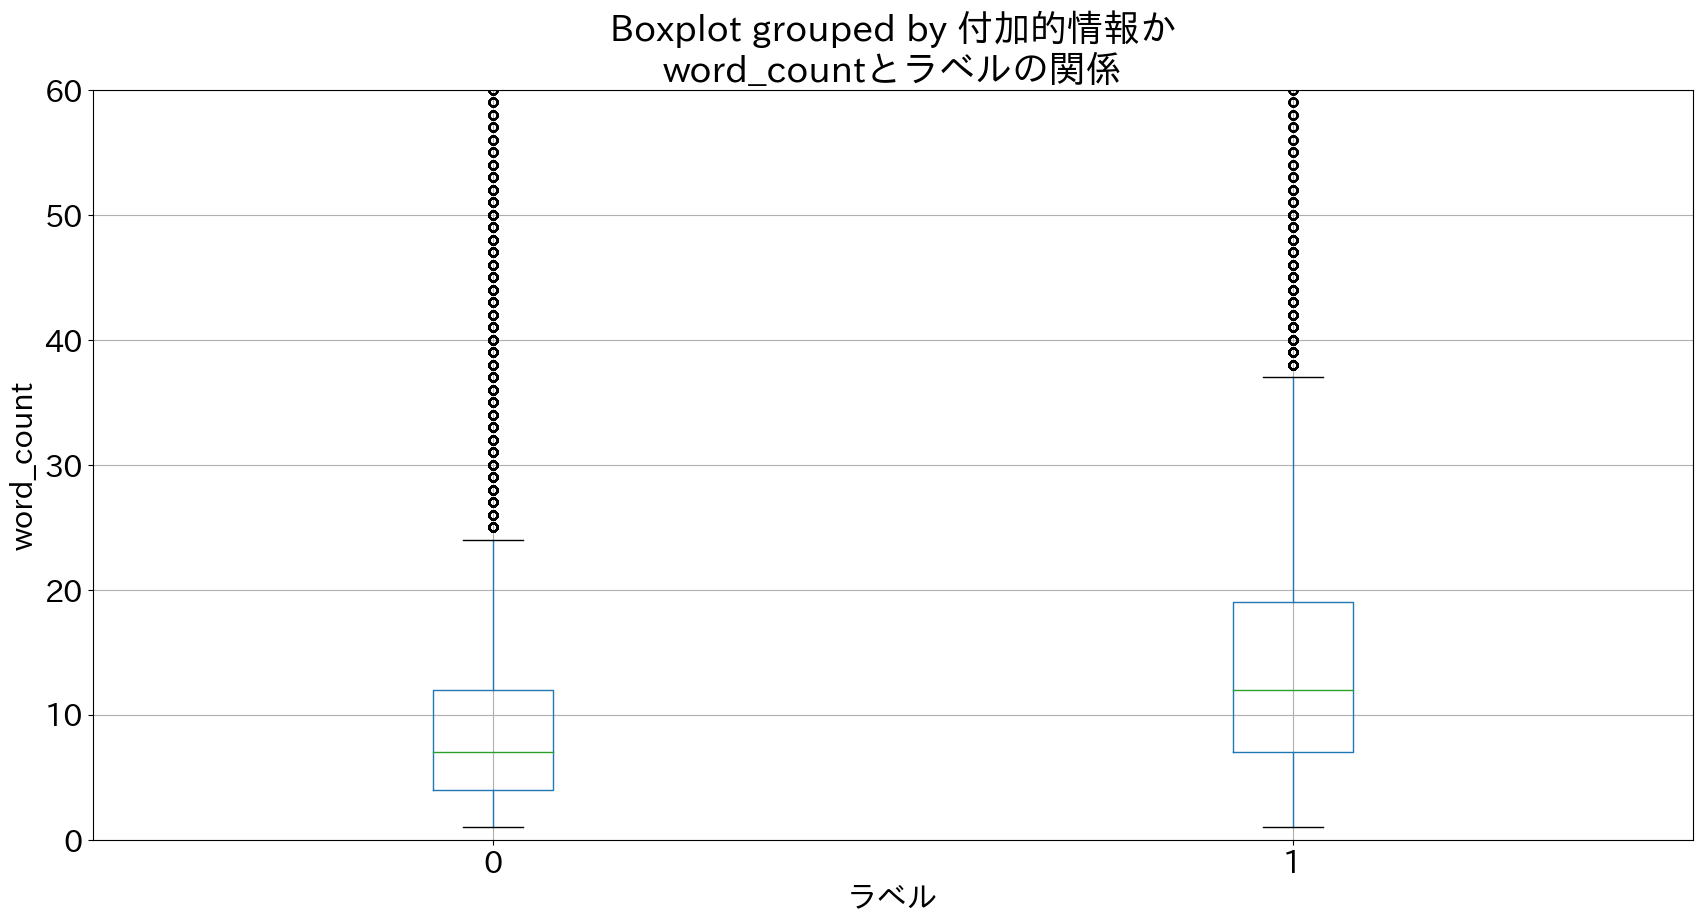

In [14]:
# ラベルの特徴
# word_countとラベルの関係 箱ひげ図で可視化
def label_by_column(column: str, df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(20, 10))
    filtered_df = df.loc[df[binary_category_name].isin([0, 1])]

    filtered_df.boxplot(column=column, by=binary_category_name, ax=ax)
    ax.set_ylim(0, 60)
    ax.set_xlabel("ラベル")
    ax.set_ylabel(column)
    ax.set_title(f"{column}とラベルの関係")
    fig.savefig(f"database/images/scbi_v2-label_by_{column}.png")

label_by_column("word_count", scbi_df)

In [ ]:
scbi_df['duration'] = scbi_df['end'] - scbi_df['start']
label_by_column("duration", scbi_df)

/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_25461/1160012974.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(lambda x: int(x) // 5 * 5)


 mu: 10.540655517523955, sigma: 9.95087290696534
 xlim: (0, 40)


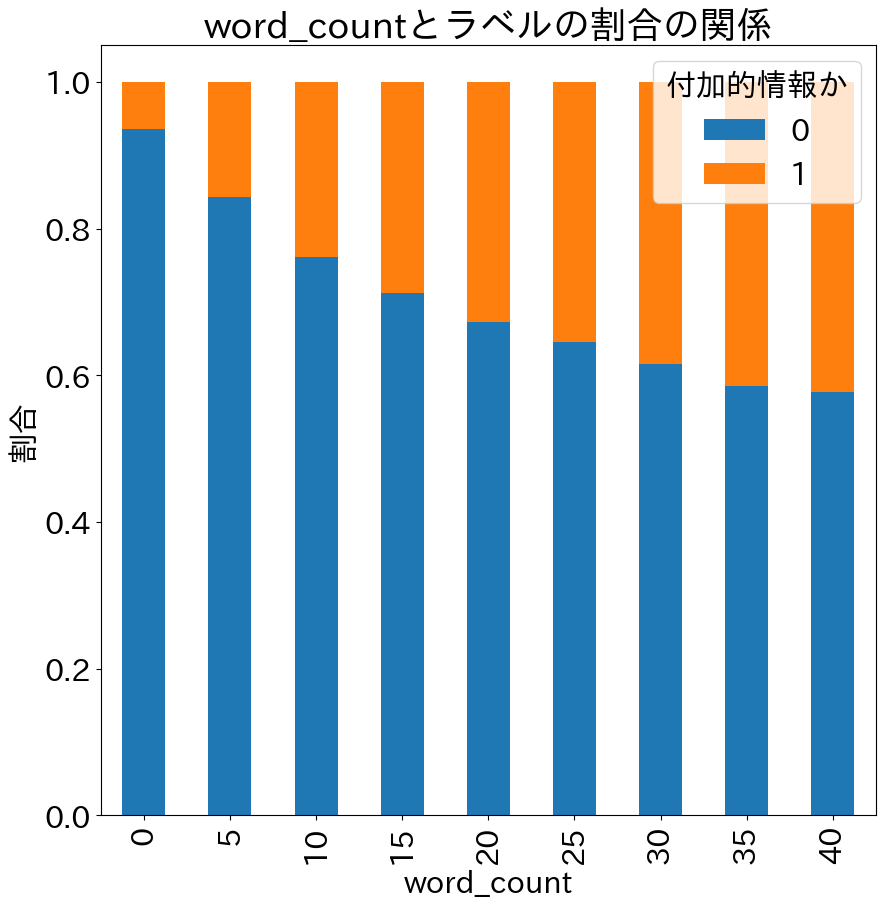

In [28]:
# word_countと binary_category_nameの割合 の相関
def plot_label_ratio_by_column(column: str, df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(10, 10))
    filtered_df = df.loc[
        (df[binary_category_name].isin([0, 1])) &
        (df[column] > 0)
    ]

    # 5で割って丸めてグルーピング
    filtered_df[column] = filtered_df[column].apply(lambda x: int(x) // 5 * 5)

    # xlimを決めるために、word_countの3シグマを計算
    mu = df[column].mean()
    sigma = df[column].std()
    xlim = (max(mu - 3 * sigma, 0), round(mu + 3 * sigma))
    print(f" mu: {mu}, sigma: {sigma}")
    print(f" xlim: {xlim}")

    # xlimの範囲でデータをフィルタリング
    filtered_df = filtered_df.loc[
        (filtered_df[column] >= xlim[0]) & (filtered_df[column] <= xlim[1])
    ]


    piv_df = filtered_df.pivot_table(
        index=column, columns=binary_category_name, aggfunc="count", values="text"
    )
    piv_df = piv_df.fillna(0)
    # 割合に変換?
    piv_df = piv_df.div(piv_df.sum(axis=1), axis=0)

    piv_df.plot(
        kind="bar",
        stacked=True,
        ax=ax,
    )

    ax.set_xlabel(column)
    ax.set_ylabel("割合")
    ax.set_title(f"{column}とラベルの割合の関係")

    fig.savefig(f"database/images/scbi_v2-label_ratio_by_{column}.png")


plot_label_ratio_by_column("word_count", scbi_df)
# 文字数が多いほど付加的情報の割合が高い という当たり前のことを示した

相関係数: 0.8211020954089634
回帰係数: [0.27554967]
切片: 0.471661206304101


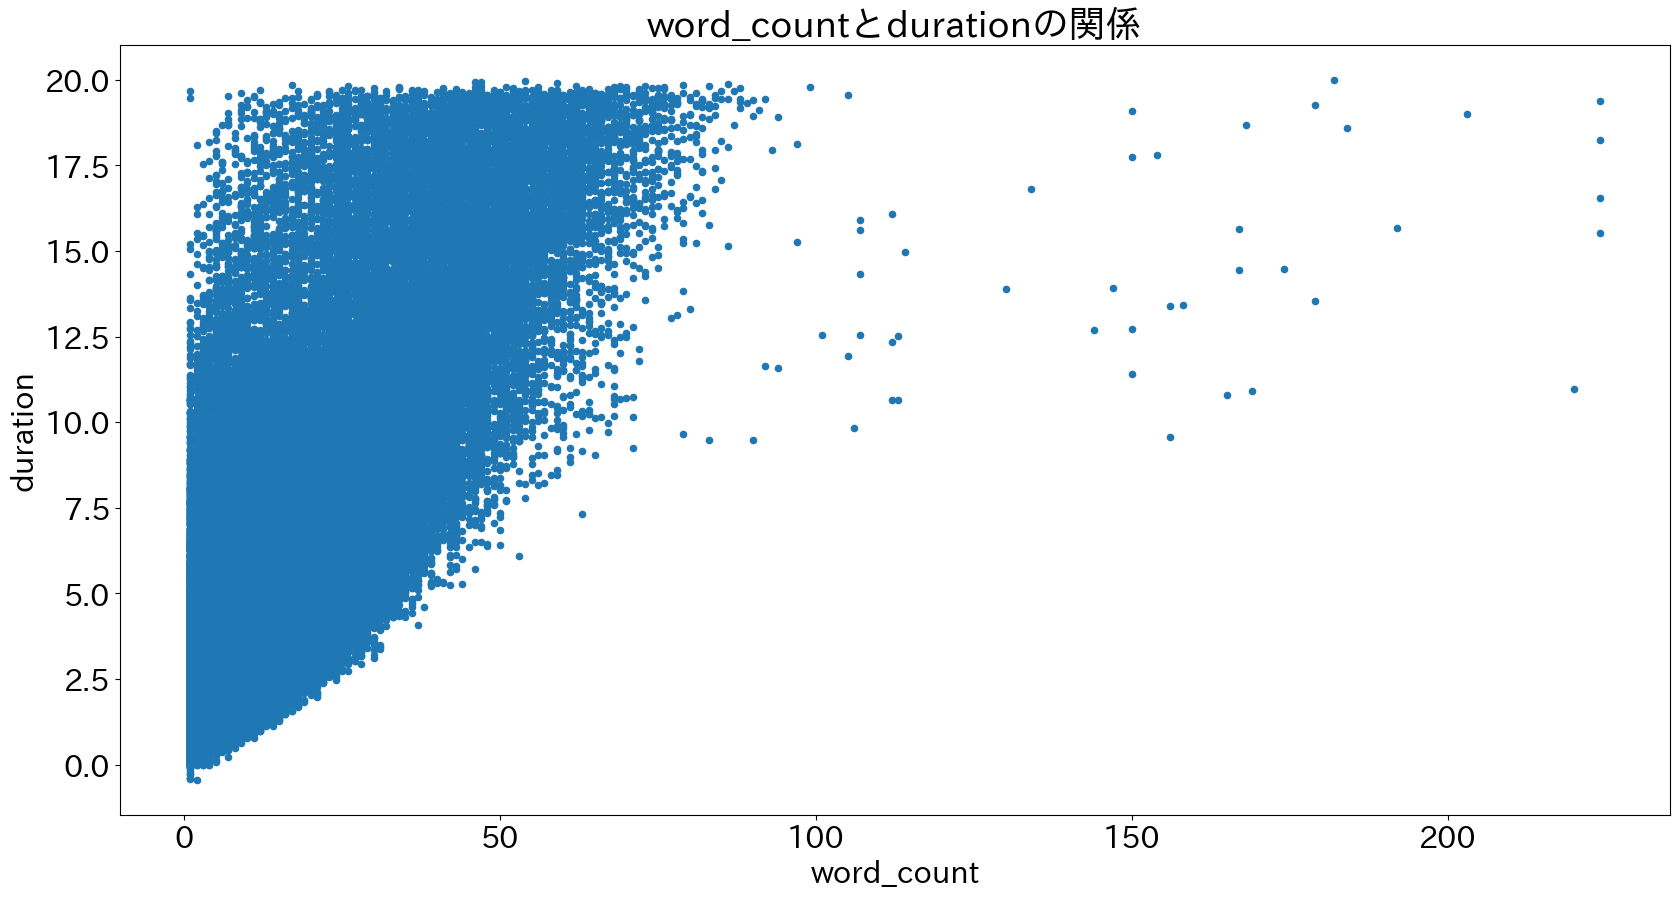

In [30]:
from sklearn.linear_model import LinearRegression


# 文字数とdurationの相関
def plot_duration_by_word_count(df: pd.DataFrame):
    # 文字の長さを確認
    df['word_count'] = df['text'].str.split().str.len()
    df["duration"] = df["end"] - df["start"]
    filtered_df = df.loc[df['word_count'] > 0]

    # 相関係数
    print(f"相関係数: {filtered_df['word_count'].corr(filtered_df['duration'])}")
    # 線形回帰
    lr = LinearRegression()
    lr.fit(filtered_df[['word_count']], filtered_df['duration'])
    print(f"回帰係数: {lr.coef_}")
    print(f"切片: {lr.intercept_}")

    fig, ax = plt.subplots(figsize=(20, 10))
    filtered_df.plot.scatter(x='word_count', y='duration', ax=ax)
    ax.set_xlabel("word_count")
    ax.set_ylabel("duration")
    ax.set_title("word_countとdurationの関係")
    fig.savefig("database/images/scbi_v2-duration_by_word_count.png")

plot_duration_by_word_count(scbi_df)
# ほぼ比例している r = 0.821
# 音声区間長 = 0.275 * 文字数 + 0.471

In [9]:
# word count と 沈黙時間の相関
def plot_silence_by_word_count(df: pd.DataFrame):
    # 文字の長さを確認
    df['word_count'] = df['text'].str.split().str.len()
    df["prev_end"] = df["end"].shift(1)
    df["silence"] = df["start"] - df["prev_end"]
    df.loc[df["silence"] < 0, "silence"] = None
    filtered_df = df.loc[(df['word_count'] > 0) & (df['silence'] > 0)]

    text_length_interval = filtered_df["word_count"].mean()
    print(f"text_lengthの平均: {text_length_interval}")
    for interval in [10, 20, 30]:
        filtered_df[f"silence_over_{interval}"] = (
            filtered_df["silence"] > interval
        )
        text_length_long_interval = filtered_df[
            (filtered_df[f"silence_over_{interval}"] == 1)]["word_count"].mean()
        print(f"{interval}秒の text_length の平均: {text_length_long_interval}")

plot_silence_by_word_count(scbi_df)

text_lengthの平均: 10.525531668875468
10秒の text_length の平均: 11.300481659874027
20秒の text_length の平均: 8.700139470013948
30秒の text_length の平均: 7.986254295532646


/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_19411/1033755219.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[f"silence_over_{interval}"] = (
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_19411/1033755219.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[f"silence_over_{interval}"] = (
/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_19411/1033755219.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

Text(0.5, 1.0, '擬似沈黙時間と単語数の関係')

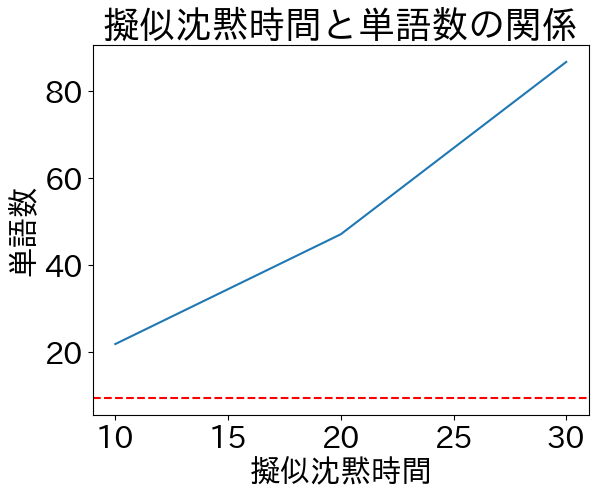

In [44]:
plt.plot([10, 20, 30], [21.771928661406882, 47.05904897090135,  86.75503000352982
])
plt.xlabel("擬似沈黙時間")
plt.ylabel("単語数")
plt.axhline(y=9.36107030087637, color='r', linestyle='--')
plt.title("擬似沈黙時間と単語数の関係")

In [ ]:
plt.plot([10, 20, 30], [11.300481659874027, 8.700139470013948, 7.986254295532646
])
plt.xlabel("沈黙時間")
plt.ylabel("単語数")
plt.axhline(y=10.5, color='r', linestyle='--')
plt.title("沈黙時間と単語数の関係")

In [ ]:
# sn-echoes avarage unique word ratio
# (unique word count divided by the the number of total words)
def avg_unique_word_ratio(df: pd.DataFrame):
    # unique_word_ratio を video (game, half) ごとに計算して平均を取る
    filtered_df = df.loc[df['text'].notnull()].copy()

    group_per_video = filtered_df.groupby(['game', 'half'])
    text_chunk = group_per_video['text'].apply(lambda x: ' '.join(x))
    unique_word_ratio = text_chunk.apply(
        lambda x: len(set(x.split())) / len(x.split())
    )

    # 平均を取る
    avg_unique_word_ratio = unique_word_ratio.mean()
    print(f"Average unique word ratio: {avg_unique_word_ratio:.3f}")
avg_unique_word_ratio(scbi_df)

# 結果、Average unique word ratio: 0.292
# sn-echoesは large-v3で0.370だった
# 低い->書き起こしの品質が悪いと、sn-echoesでは仮定していたけど、そもそもそれは間違いだと考えるべき

In [20]:
# sn-echoes にある、述語目的語の割合 円グラフを scbi-v2 に適用してみる
from collections import Counter

import nltk
import plotly.express as px
from nltk import pos_tag, word_tokenize
from nltk.corpus import (
    stopwords,  # Import the stop word list
    wordnet,
)

# 必要なデータをダウンロード
nltk.download('all')

nltk.data.path.append('/Users/heste/nltk_data')

stops = set(stopwords.words("english"))
stemmer = nltk.WordNetLemmatizer()

# 品詞タグをWordNetの形式に変換する関数
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


# 動詞-目的語ペアを抽出する関数
def extract_vn_nltk(text):
    """
    1. 文章をトークン化
    2. 品詞タグ付け
    3. stopwordを除外 3文字以上 動詞を抽出
    4. 動詞を見出し語化
    5. 動詞の後に名詞がある場合、動詞-名詞ペアを抽出
    """
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)

    vn_pairs = []
    for i, word_pos in enumerate(tagged):
        word, pos = word_pos

        #  動詞を探す stopwordを除外 3文字以上
        if pos.startswith('VB') and (word.lower() not in stops) and (len(word) >= 3):
            # 目的語となる名詞 (名詞が動詞の後にくる場合を探す)
            if i + 1 < len(tagged) and tagged[i + 1][1] in ['NN', 'NNS']:
                noun = tagged[i + 1][0].lower()
                # 動詞のみ レンマタイズ
                word = stemmer.lemmatize(word.lower(), pos=get_wordnet_pos(pos))
                vn_pairs.append((word, noun))

    return vn_pairs


def plot_vn_ratio(df: pd.DataFrame, only_bi: bool = False):
    # サンプルデータフレームのテキスト列から主語-動詞ペアを抽出
    filtered_df = df.loc[df['text'].notnull()].copy()

    if only_bi:
        # only background information
        filtered_df = filtered_df.loc[filtered_df[binary_category_name] == 1]

    filtered_df['vn_pairs'] = filtered_df['text'].progress_apply(extract_vn_nltk)

    print(filtered_df['vn_pairs'].str.len().describe())

    # 動詞ごとの集計
    vn_list = [
        (v, n)
        for pairs in filtered_df['vn_pairs']
        for v, n in pairs
        if len(pairs) > 0
    ]

    # 動詞の上位20個を取得
    v_list = [v for v, _ in vn_list]
    top_20_verbs = [v for v, _ in Counter(v_list).most_common(20)]

    print(f"{top_20_verbs=}")

    # 動詞ごとの目的語の上位を制限して取得
    filtered_pairs = []
    for verb in top_20_verbs:
        nouns = []
        for v, n in vn_list:
            if v == verb:
                nouns.append(n)

        noun_counts = Counter(nouns)
        print(f"{noun_counts=}")
        # 動詞の順位に応じた目的語の表示数を設定
        rank = top_20_verbs.index(verb) + 1
        if rank <= 3:
            top_nouns = noun_counts.most_common(4)  # 上位3位までの動詞には4個の名詞
        elif rank <= 5:
            top_nouns = noun_counts.most_common(3)  # 上位5位までの動詞には3個の名詞
        else:
            top_nouns = noun_counts.most_common(1)  # それ以外の動詞には1個の名詞

        print(f"{verb=}, {top_nouns=}")
        # 結果をリストに追加
        for noun, count in top_nouns:
            filtered_pairs.append((verb, noun, count))

    sunburst_df = pd.DataFrame(filtered_pairs, columns=['verb', 'noun', 'count'])

    # サンバーストチャートの作成
    fig = px.sunburst(
        sunburst_df,
        path=['verb', 'noun'],   # 動詞をメインセグメント、目的語をサブセグメントとして設定
        values='count',          # 頻度データ
        color='verb',            # 動詞ごとに色分け
        title="Verb-Noun 共起関係",
    )
    fig.show()

# plot_vn_ratio(scbi_df)

# take advantageが以上に多い
# 偏りがありそうなことがわかった


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/heste/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/heste/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/heste/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/heste/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/heste/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_dat

In [21]:
plot_vn_ratio(scbi_df, only_bi=True)

100%|██████████| 62668/62668 [00:24<00:00, 2603.19it/s]


count    62668.000000
mean         0.062520
std          0.264526
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: vn_pairs, dtype: float64
top_20_verbs=['take', 'get', 'make', 'score', 'give', 'win', 'lose', 'play', 'start', 'say', 'see', 'leave', 'put', 'create', 'attack', 'find', 'set', 'keep', 'repeat', 'change']
noun_counts=Counter({'advantage': 187, 'care': 28, 'place': 26, 'part': 14, 'charge': 12, 'something': 8, 'control': 7, 'risks': 6, 'time': 6, 'possession': 5, 'goal': 4, 'speed': 4, 'shape': 2, 'anything': 2, 'penalty': 2, 'hold': 2, 'confidence': 2, 'air': 2, 'height': 2, 'crosses': 1, 'corners': 1, 'shots': 1, 'nothing': 1, 'delaney': 1, 'office': 1, 'penalties': 1, 'exception': 1, 'sides': 1, 'chances': 1, 'numbers': 1, 'eye': 1, 'videos': 1, 'positions': 1, 'options': 1, 'refuge': 1, 'everything': 1, '5-0': 1, 'support': 1, 'knowledge': 1, 'home': 1, 'position': 1, 'momentum': 1, 'notes': 1, 'minutes':

In [ ]:
# より詳細な分析のため、シーズンやチームごとにデータを分割
# game -> (ex.) england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley
# game -> league, season, date, kickoff-time, home-team, home-score, away-team, away-score
import re


def extract_data_from_game(game: str):
    league, season, match_data = game.split('/')
    # regexで抽出する
    date = re.search(r'\d{4}-\d{2}-\d{2}', match_data).group()
    kickoff_time = re.search(r'\d{2}-\d{2}', match_data).group()

    # score は 空白 数字 - 数字 空白
    home_score = int(re.search(r' (\d) - \d ', match_data).group(1))
    away_score = int(re.search(r' \d - (\d) ', match_data).group(1))

    # home-team は、 kickoff_time の後から score の前まで
    home_team = re.search(r' \d{2}-\d{2} (.*) \d - \d ', match_data).group(1)
    # away-teamは、scoreの後から終わりまで
    away_team = re.search(r' \d - \d (.*)', match_data).group(1)

    return {
        "league": league,
        "season": season,
        "date": date,
        "kickoff_time": kickoff_time,
        "home_team": home_team,
        "home_score": home_score,
        "away_score": away_score,
        "away_team": away_team,
    }
scbi_df = scbi_df.dropna(subset=['game'])
# ゲームデータを抽出
game_metadata_df = pd.DataFrame(scbi_df['game'].apply(extract_data_from_game).tolist())
# データの結合 # indexが同じなので、そのまま結合
scbi_df = pd.concat([scbi_df, game_metadata_df], axis=1)
scbi_df.head()

In [13]:
# 沈黙時間平均 2.14
assert "silence" in scbi_df.columns
print(f"{scbi_df['silence'].median()=}")

def over_1sec_silence_analysis(df: pd.DataFrame):
    """
    filter: 1秒以上のsilence
    silence col の 平均, 中央値, 分布 を表示
    ラベルの割合も表示
    """
    df_over_1sec = df.loc[df['silence'] >= 1]
    print(f"{df_over_1sec['silence'].mean()=}")
    print(f"{df_over_1sec['silence'].median()=}")
    print(df_over_1sec['silence'].describe())
    print(df_over_1sec[binary_category_name].value_counts(normalize=True))

over_1sec_silence_analysis(scbi_df)

scbi_df['silence'].median()=0.18000000000029104
df_over_1sec['silence'].mean()=5.581917857056045
df_over_1sec['silence'].median()=3.300000000000182
count    123419.000000
mean          5.581918
std           6.123918
min           1.000000
25%           1.760000
50%           3.300000
75%           7.000000
max         135.640000
Name: silence, dtype: float64
付加的情報か
 0    0.799966
 1    0.199994
 2    0.000032
-1    0.000008
Name: proportion, dtype: float64


In [31]:
# 言語ごとの付加的情報の割合を計算
def label_ratio_by_language(df: pd.DataFrame):
    # languageごとの付加的情報の割合を計算
    language_grouped = df.groupby('language')
    for language, group_df in language_grouped:
        print(f"言語: {language}, 試合数: {group_df['game'].nunique()}")
        print(group_df[binary_category_name].value_counts(normalize=True))
        print(group_df[binary_category_name].value_counts())

label_ratio_by_language(scbi_df)

# 結果、試合数が多い言語間での差はなさそう

言語: cy, 試合数: 1
付加的情報か
0    0.659864
1    0.340136
Name: proportion, dtype: float64
付加的情報か
0    97
1    50
Name: count, dtype: int64
言語: de, 試合数: 60
付加的情報か
0    0.795752
1    0.204226
2    0.000022
Name: proportion, dtype: float64
付加的情報か
0    35664
1     9153
2        1
Name: count, dtype: int64
言語: en, 試合数: 133
付加的情報か
0    0.804895
1    0.195078
2    0.000027
Name: proportion, dtype: float64
付加的情報か
0    89246
1    21630
2        3
Name: count, dtype: int64
言語: es, 試合数: 125
付加的情報か
 0    0.827471
 1    0.172510
-1    0.000013
 2    0.000006
Name: proportion, dtype: float64
付加的情報か
 0    130148
 1     27133
-1         2
 2         1
Name: count, dtype: int64
言語: fr, 試合数: 19
付加的情報か
0    0.809094
1    0.190906
Name: proportion, dtype: float64
付加的情報か
0    16228
1     3829
Name: count, dtype: int64
言語: it, 試合数: 2
付加的情報か
0    0.837321
1    0.161996
2    0.000684
Name: proportion, dtype: float64
付加的情報か
0    1225
1     237
2       1
Name: count, dtype: int64
言語: pl, 試合数: 1
付加的情報か
0    0.736752
1 

In [32]:
# リーグごとの付加的情報の割合を計算

def label_ratio_by_league(df: pd.DataFrame):
    # leagueごとの付加的情報の割合を計算
    league_grouped = df.groupby('league')
    for league, group_df in league_grouped:
        print(f"リーグ: {league}, 試合数: {group_df['game'].nunique()}")
        print(group_df[binary_category_name].value_counts(normalize=True))
        print(group_df[binary_category_name].value_counts())

label_ratio_by_league(scbi_df)

# england_epl, europe_uefa-champions-league　は比較的多め
# 何が言えそうかわからない

リーグ: england_epl, 試合数: 84
付加的情報か
0    0.809393
1    0.190581
2    0.000027
Name: proportion, dtype: float64
付加的情報か
0    60923
1    14345
2        2
Name: count, dtype: int64
リーグ: europe_uefa-champions-league, 試合数: 84
付加的情報か
0    0.803558
1    0.196430
2    0.000013
Name: proportion, dtype: float64
付加的情報か
0    63424
1    15504
2        1
Name: count, dtype: int64
リーグ: france_ligue-1, 試合数: 9
付加的情報か
0    0.795757
1    0.204243
Name: proportion, dtype: float64
付加的情報か
0    7165
1    1839
Name: count, dtype: int64
リーグ: germany_bundesliga, 試合数: 50
付加的情報か
0    0.796719
1    0.203255
2    0.000026
Name: proportion, dtype: float64
付加的情報か
0    30641
1     7817
2        1
Name: count, dtype: int64
リーグ: italy_serie-a, 試合数: 14
付加的情報か
0    0.830259
1    0.169666
2    0.000075
Name: proportion, dtype: float64
付加的情報か
0    11118
1     2272
2        1
Name: count, dtype: int64
リーグ: spain_laliga, 試合数: 98
付加的情報か
 0    0.830089
 1    0.169887
-1    0.000016
 2    0.000008
Name: proportion, dtype: float64
付加

In [35]:
# シーズンを4つに分割して、それぞれの付加的情報の割合を計算
from datetime import datetime


def month_to_phase(month: int):
    if month in [6, 7, 8]:
        return "シーズンオフ"
    elif month in [9, 10, 11]:
        return "序盤"
    elif month in [12, 1, 2]:
        return "中盤"
    else:
        return "終盤"


def label_ratio_by_season(df: pd.DataFrame):
    # seasonごとの付加的情報の割合を計算
    # (シーズンオフ)6~8, (序盤)9~11, (中盤)12~2, (終盤)3~5
    df["season_phase"] = df["date"].apply(lambda x: month_to_phase(datetime.strptime(x, "%Y-%m-%d").month))
    season_grouped = df.groupby('season_phase')
    for season, group_df in season_grouped:
        print(f"シーズン: {season}, 試合数: {group_df['game'].nunique()}")
        print(group_df[binary_category_name].value_counts(normalize=True))
        print(group_df[binary_category_name].value_counts())
        print()


label_ratio_by_season(scbi_df)

# 結果：
# 序盤 0.196818 -> 中盤 0.183680 -> 終盤 0.175579
# 序盤から終盤に向かって映像の説明が増える(付加的情報の割合が減る)

シーズン: シーズンオフ, 試合数: 20
付加的情報か
0    0.816222
1    0.183680
2    0.000098
Name: proportion, dtype: float64
付加的情報か
0    16695
1     3757
2        2
Name: count, dtype: int64

シーズン: 中盤, 試合数: 77
付加的情報か
0    0.81658
1    0.18342
Name: proportion, dtype: float64
付加的情報か
0    60520
1    13594
Name: count, dtype: int64

シーズン: 序盤, 試合数: 122
付加的情報か
 0    0.803149
 1    0.196818
 2    0.000025
-1    0.000008
Name: proportion, dtype: float64
付加的情報か
 0    97238
 1    23829
 2        3
-1        1
Name: count, dtype: int64

シーズン: 終盤, 試合数: 120
付加的情報か
 0    0.824405
 1    0.175579
 2    0.000008
-1    0.000008
Name: proportion, dtype: float64
付加的情報か
 0    100894
 1     21488
 2         1
-1         1
Name: count, dtype: int64



In [42]:
# 話者ごとの付加的情報の割合の差を計算
# speaker id は videoごとで別物だから
# 1. videoごとでコメントをまとめる
# 2. コメント数上位二人 の speaker idを取得
# 3. speaker ごとの付加的情報の割合を計算
# 4. speaker ごとの付加的情報の割合の差を計算

def label_ratio_by_speaker(df: pd.DataFrame):
    """話者ごとの付加的情報の割合の差を計算
    speaker id は videoごとで別物だから
    1. videoごとでコメントをまとめる
    2. コメント数上位二人 の speaker idを取得
    3. speaker ごとの付加的情報の割合を計算
    4. speaker ごとの付加的情報の割合の差を計算
    Args:
        df (pd.DataFrame): コメントデータ
    """
    # videoごとでコメントをまとめる
    group_per_video = df.groupby(['game', 'half'])
    speaker_diffs = {}
    for (game, half), video_df in group_per_video:
        # speaker id ごとの付加的情報の割合を計算
        speaker_ratios = []
        speaker_grouped = video_df.groupby('speaker')
        for speaker, speaker_df in speaker_grouped:
            comment_num = len(speaker_df)
            speaker_ratio = speaker_df[binary_category_name].value_counts(normalize=True).get(1.0, 0)
            speaker_ratios.append((speaker, comment_num, speaker_ratio))

        # コメント数上位二人 の speaker idを取得
        top_speakers = sorted(speaker_ratios, key=lambda x: x[1], reverse=True)[:2]

        # speaker idごと情報を表示
        print(f"{game=}, {half=}")
        for speaker, comment_num, speaker_ratio in top_speakers:
            print(f"{speaker=} {comment_num=} ratio:{speaker_ratio:.2f}")

        # diffを計算
        try:
            speaker_diffs[(game, half)] = abs(top_speakers[0][2] - top_speakers[1][2])
        except IndexError:
            print(f"Error: {top_speakers=}")
            pass

        print()

    # avg speaker_diffsを表示
    avg_diff = np.mean(list(speaker_diffs.values()))
    print(f"avg speaker_diffs: {avg_diff:.3f}")

label_ratio_by_speaker(scbi_df)

# 結果 avg speaker_diffs: 0.083
# 十分大きい差がありそう
# max_speaker_num=2 とか、さらにちゃんと話者分離すると、もっと大きな差が出るかもしれない

game='england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley', half=1.0
speaker='SPEAKER_01' comment_num=342 ratio:0.19
speaker='SPEAKER_00' comment_num=190 ratio:0.19

game='england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley', half=2.0
speaker='SPEAKER_00' comment_num=351 ratio:0.14
speaker='SPEAKER_02' comment_num=200 ratio:0.10

game='england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United', half=1.0
speaker='SPEAKER_01' comment_num=205 ratio:0.20
speaker='SPEAKER_04' comment_num=192 ratio:0.28

game='england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United', half=2.0
speaker='SPEAKER_02' comment_num=257 ratio:0.21
speaker='SPEAKER_01' comment_num=207 ratio:0.17

game='england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool', half=1.0
speaker='SPEAKER_01' comment_num=179 ratio:0.26
speaker='SPEAKER_00' comment_num=171 ratio:0.14

game='england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool', half=2.0
spe

In [22]:
from scipy.stats import expon, gamma, lognorm


# サンプルデータ (例として生成しています。実際にはここにデータを読み込んでください)
# data = np.array([...])  # ここに実際のデータを代入してください
def estimate_and_plot_dist(df, ignore_under_1=False):
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))
    data = df['silence'].copy()
    if ignore_under_1:
        data = data[data > 1]
    data = data[data <= 60]
    data = data[np.isfinite(data)]
    data = data.dropna()
    print(data.describe())

    data.hist(bins=100, alpha=0.6, color='b', edgecolor='black', ax=ax[0,0])
    ax[0, 0].set_xlim(0, 60)
    ax[0, 0].set_title("Silence distribution", fontsize=15)

    # 指数分布でフィッティング
    loc, scale = expon.fit(data, floc=1.0 if ignore_under_1 else 0)
    print(f"指数分布のパラメータ: loc = {loc:.4f}, scale = {scale:.4f}")
    x = np.linspace(0, np.max(data), 100)
    pdf_fitted = expon.pdf(x, loc=loc, scale=scale)
    ax[0, 1].hist(data, bins=60, density=True, alpha=0.6, color='b', edgecolor='black')
    ax[0, 1].plot(x, pdf_fitted, 'r-')
    ax[0, 1].set_xlim(0, 60)
    ax[0, 1].set_title("指数分布", fontsize=15)


    # 対数正規分布でフィッティング
    shape, loc, scale = lognorm.fit(data, floc=1.0 if ignore_under_1 else 0)
    print(f"対数正規分布のパラメータ: shape = {shape:.4f}, loc = {loc:.4f}, scale = {scale:.4f}")
    # フィッティング結果をプロット
    ax[1,0].hist(data, bins=60, density=True, alpha=0.6, color='b', edgecolor='black')
    x = np.linspace(0, np.max(data), 100)
    pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale)
    ax[1,0].plot(x, pdf_fitted, 'r-')
    ax[1,0].set_xlim(0, 60)
    ax[1,0].set_title("対数正規分布", fontsize=15)

    # ガンマ分布でフィッティング
    shape, loc, scale = gamma.fit(data, floc=1.0 if ignore_under_1 else 0)
    print(f"ガンマ分布のパラメータ: shape = {shape:.4f}, loc = {loc:.4f}, scale = {scale:.4f}")
    # フィッティング結果をプロット
    ax[1,1].hist(data, bins=60, density=True, alpha=0.6, color='b', edgecolor='black')
    x = np.linspace(0, np.max(data), 100)
    pdf_fitted = gamma.pdf(x, shape, loc=loc, scale=scale)
    ax[1,1].plot(x, pdf_fitted, 'r-')
    ax[1,1].set_xlim(0, 60)
    ax[1,1].set_title("ガンマ分布", fontsize=15)

    fig.tight_layout()


count    337234.000000
mean          2.128950
std           4.446884
min           0.010000
25%           0.020000
50%           0.180000
75%           2.060000
max          59.920000
Name: silence, dtype: float64
指数分布のパラメータ: loc = 0.0000, scale = 2.1289
対数正規分布のパラメータ: shape = 2.2926, loc = 0.0000, scale = 0.2688
ガンマ分布のパラメータ: shape = 0.3283, loc = 0.0000, scale = 6.4844


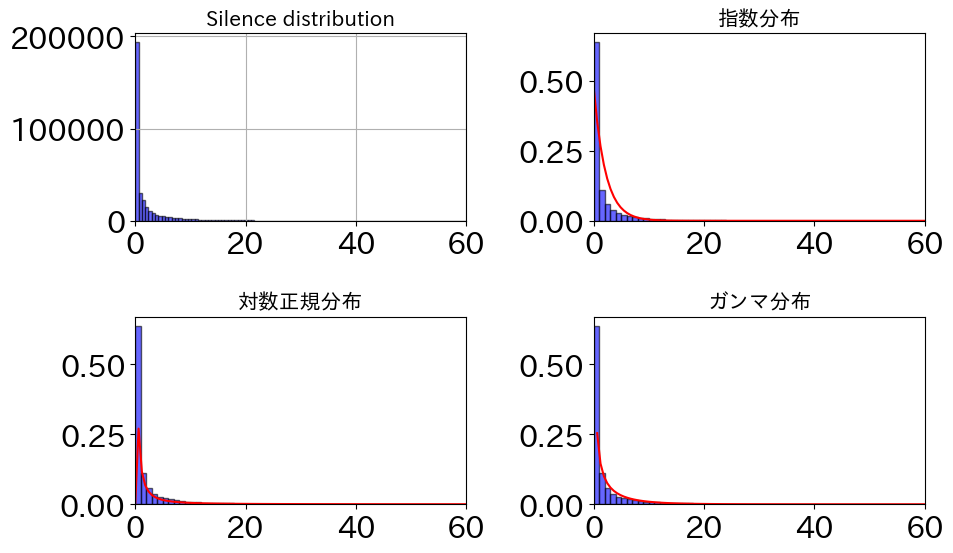

In [23]:
estimate_and_plot_dist(scbi_df, ignore_under_1=False)

count    122654.000000
mean          5.579384
std           5.962530
min           1.000000
25%           1.770000
50%           3.330000
75%           7.030000
max          59.920000
Name: silence, dtype: float64
指数分布のパラメータ: loc = 1.0000, scale = 4.5794
対数正規分布のパラメータ: shape = 1.4900, loc = 1.0000, scale = 1.9811
ガンマ分布のパラメータ: shape = 0.7186, loc = 1.0000, scale = 6.3723


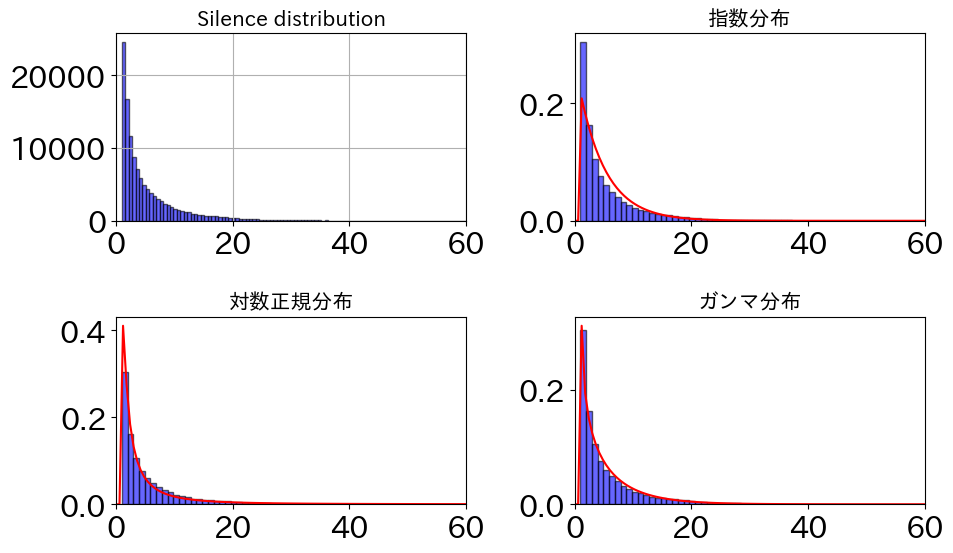

In [25]:
estimate_and_plot_dist(scbi_df, ignore_under_1=True)

In [ ]:
# 多項分布のフィッティング
def estimate_and_plot_dist_poly(df):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    data = df['silence'].copy()
    data = data[data <= 60]
    data = data[np.isfinite(data)]
    data = data.dropna()
    print(data.describe())

    data.hist(bins=100, alpha=0.6, color='b', edgecolor='black', ax=ax)
    ax.set_xlim(0, 60)
    ax.set_title("Silence distribution", fontsize=15)

    # 多項分布でフィッティング
    loc, scale = expon.fit(data, floc=0)
    print(f"指数分布のパラメータ: loc = {loc:.4f}, scale = {scale:.4f}")
    x = np.linspace(0, np.max(data), 100)
    pdf_fitted = expon.pdf(x, loc=loc, scale=scale)
    ax.hist(data, bins=60, density=True, alpha=0.6, color='b', edgecolor='black')
    ax.plot(x, pdf_fitted, 'r-')
    ax.set_xlim(0, 60)
    ax.set_title("Fitted Exponential distribution", fontsize=15)

    fig.tight_layout()

In [44]:
# フレームごとのLaplace varianceと付加的情報の割合の相関
import traceback
from functools import partial
from multiprocessing import Pool

import cv2
from tap import Tap


class Args(Tap):
    soccernet_path: str = "/raid_elmo/home/lr/moriy/SoccerNet"
    resolution: str = "224p"
    scbi_csv: str = "scbi_v2.csv"


def get_frame(file_path, time):
    cap = cv2.VideoCapture(file_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(time * fps))
    ret, frame = cap.read()
    cap.release()
    return frame


def get_laplacian_variance(frame):
    """
    フレームのシャープさを表すLaplacian varianceを計算
    画像シャープであれば、Laplacian varianceは大きくなる(はず)
    return ラプラシアンの分散
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian_abs = np.abs(laplacian)
    variance = np.var(laplacian_abs)
    return variance


def get_laplacian_sum(frame):
    """
    フレームのシャープさを表すLaplacian varianceを計算
    return ラプラシアンの合計
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian_abs = np.abs(laplacian)
    return np.sum(laplacian_abs)


def calc_laplacian_variance(row, soccernet_path, resolution, method="variance", duration="frame"):
    if method == "variance":
        get_laplacian = get_laplacian_variance
    elif method == "sum":
        get_laplacian = get_laplacian_sum

    # フレームごとのLaplacian varianceを計算
    game = row['game']
    half = int(row['half'])
    time = float(row['start'])

    video_path = os.path.join(soccernet_path, game, f"{half}_{resolution}.mkv")

    if duration == "frame":
        try:
            frame = get_frame(video_path, time)
            return get_laplacian(frame)
        except Exception:
            return None
    elif duration == "mean_before_15sec":
        try:
            frames = [get_frame(video_path, max(time - i, 0)) for i in range(15)]
            with Pool(15) as p:
                return np.mean(p.map(get_laplacian, frames))
        except Exception:
            traceback.print_exc()
            return None
    else:
        raise ValueError(f"Invalid duration: {duration}")


if __name__ == "__main__" and False:
    args = Args().parse_args()
    soccernet_path = args.soccernet_path
    resolution = args.resolution
    scbi_csv = args.scbi_csv

    scbi_df = pd.read_csv(scbi_csv)
    partial_calc_laplacian_variance = partial(calc_laplacian_variance, soccernet_path=soccernet_path, resolution=resolution)
    scbi_df['laplacian_variance'] = scbi_df.progress_apply(calc_laplacian_variance, axis=1)
    scbi_df.to_csv("scbi_v2_laplacian_variance.csv", index=False)

In [19]:

from SoccerNet.Downloader import SoccerNetDownloader

downloader = SoccerNetDownloader("../SoccerNet/")
downloader.password = os.getenv("SOCCERNET_PASSWORD")

downloader.downloadGame(
    "england_epl/2015-2016/2015-08-23 - 15-30 West Brom 2 - 3 Chelsea",
    files=["1_224p.mkv", "1_720p.mkv", "2_224p.mkv", "2_720p.mkv"]
)

password required for ../SoccerNet/england_epl/2015-2016/2015-08-23 - 15-30 West Brom 2 - 3 Chelsea/1_224p.mkv
password required for ../SoccerNet/england_epl/2015-2016/2015-08-23 - 15-30 West Brom 2 - 3 Chelsea/1_720p.mkv
password required for ../SoccerNet/england_epl/2015-2016/2015-08-23 - 15-30 West Brom 2 - 3 Chelsea/2_224p.mkv
password required for ../SoccerNet/england_epl/2015-2016/2015-08-23 - 15-30 West Brom 2 - 3 Chelsea/2_720p.mkv


In [45]:
game = "england_epl/2015-2016/2015-08-23 - 15-30 West Brom 2 - 3 Chelsea"

sample_game_df = scbi_df[scbi_df['game'] == game]


partial_calc_laplacian_variance = partial(
    calc_laplacian_variance,
    soccernet_path="../SoccerNet/",
    resolution="720p",
    method="variance",
    duration="mean_before_15sec" # 20分かかる
)
sample_game_df['laplacian_variance'] = sample_game_df.apply(partial_calc_laplacian_variance, axis=1)

Process SpawnPoolWorker-1:
Traceback (most recent call last):
Process SpawnPoolWorker-2:
  File "/Users/heste/.pyenv/versions/3.11.3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/heste/.pyenv/versions/3.11.3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/heste/.pyenv/versions/3.11.3/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/heste/.pyenv/versions/3.11.3/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'get_laplacian_variance' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/Users/heste/.pyenv/versions/3.11.3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/heste/.pyenv/versions/3.11.3/lib/python3.1

KeyboardInterrupt: 

                    laplacian_variance    付加的情報か
laplacian_variance            1.000000 -0.055122
付加的情報か                       -0.055122  1.000000


laplacian_variance    Axes(0.125,0.11;0.775x0.77)
dtype: object

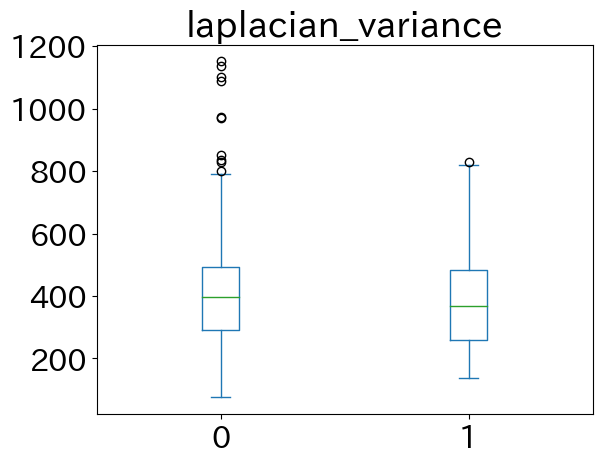

In [43]:
# 付加的情報の割合とLaplacian varianceの相関

"""
そのフレームだけの laplacian_variance と 付加的情報の割合の相関
結果: 逆相関。。。。（なんで？）
                laplacian_variance    付加的情報か
laplacian_variance            1.000000 -0.102063
付加的情報か                       -0.102063  1.000000
"""

print(sample_game_df[['laplacian_variance', binary_category_name]].corr())

sample_game_df[['laplacian_variance', binary_category_name]].plot.box(by=binary_category_name)

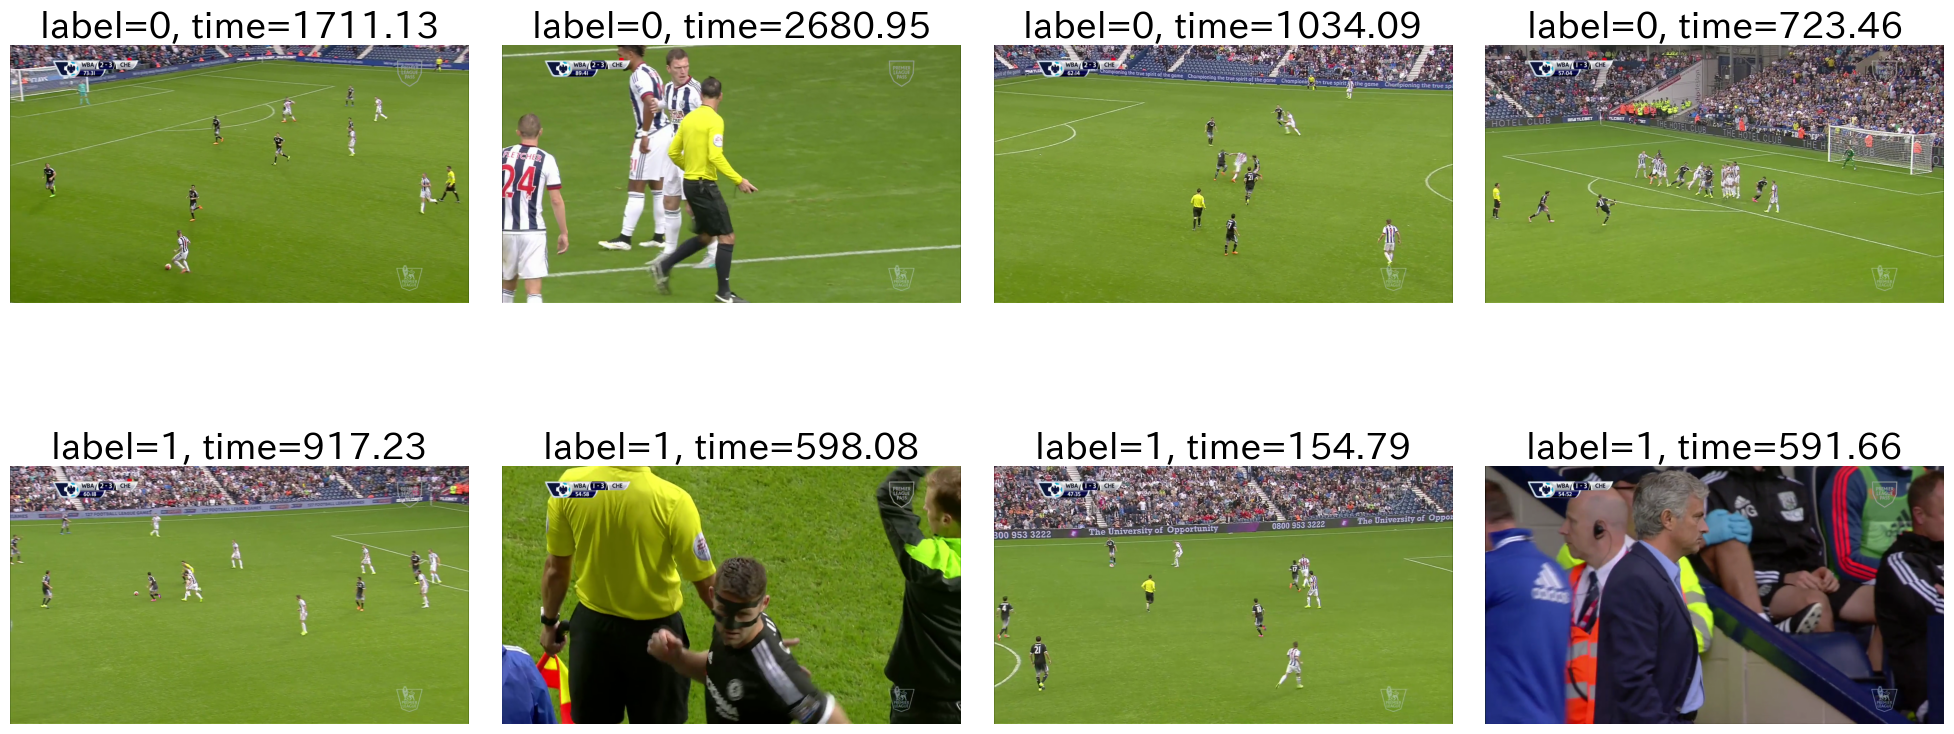

In [26]:
# binary category name ごとに 4つずつフレームを表示
# 画像のシャープさと付加的情報の割合の関係、なさそう？？

def plot_frame_by_binary_category(df: pd.DataFrame):
    # 二値カテゴリのユニーク値を取得 (例: [0, 1] など)
    categories = sorted(df[binary_category_name].unique())

    n_categories = len(categories)
    fig, ax = plt.subplots(n_categories, 4, figsize=(20, 5 * n_categories))

    if n_categories == 1:
        ax = [ax]

    for row_idx, label in enumerate(categories):
        group_df = df[df[binary_category_name] == label]

        for col_idx, (_, row) in enumerate(group_df.sample(4).iterrows()):
            game = row['game']
            half = int(row['half'])
            time = float(row['start'])

            # 動画パスを組み立て
            video_path = os.path.join("../SoccerNet/", game, f"{half}_720p.mkv")

            # フレーム取得 (実装次第)
            frame = get_frame(video_path, time)

            # フレームをサブプロットに表示
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            ax[row_idx][col_idx].imshow(frame)
            ax[row_idx][col_idx].set_title(f"label={label}, time={time:.2f}")
            ax[row_idx][col_idx].axis('off')

    fig.tight_layout()
    plt.show()

plot_frame_by_binary_category(sample_game_df)

In [46]:
laplacian_df = pd.read_csv("database/misc/scbi_v2_laplacian_variance.csv")

/var/folders/8y/94zytg1j1h339lyf_x2r_ptr0000gn/T/ipykernel_69771/5617806.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  laplacian_df = pd.read_csv("/Users/heste/workspace/soccernet/sn-script/scbi_v2_laplacian_variance.csv")


laplacian_variance    Axes(0.125,0.11;0.775x0.77)
dtype: object

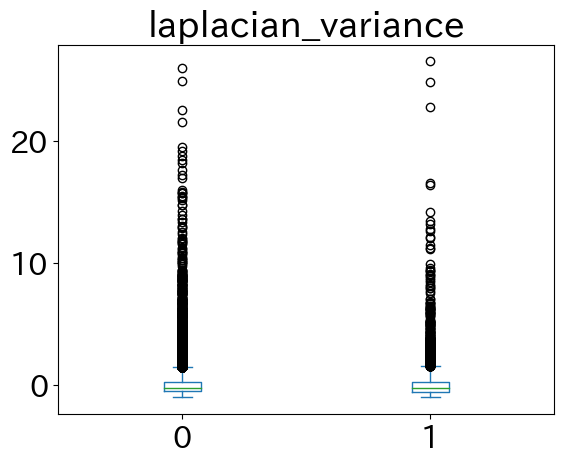

In [47]:
from sklearn.preprocessing import StandardScaler

laplacian_df = laplacian_df.dropna(subset=['laplacian_variance'])

scaler = StandardScaler()
laplacian_df['laplacian_variance'] = scaler.fit_transform(laplacian_df[['laplacian_variance']])

laplacian_df.loc[laplacian_df[binary_category_name].isin([0,1]), ['laplacian_variance', binary_category_name]].plot.box(by=binary_category_name)

In [49]:
laplacian_df.loc[
    laplacian_df[binary_category_name].isin([0,1]),
    ['laplacian_variance', binary_category_name]
].corr()

,laplacian_variance,付加的情報か
laplacian_variance,1.000000,0.002246
付加的情報か,0.002246,1.000000


## カメラタイプとの関係

### camera_dfの構成
gameTime | label
--- | ---
1 - 01:02 |	Close-up player or field referee
1 - 01:28 | 	Main camera center

↓

01:02まで，"Close-up player or field referee"

01:02から01:28まで，"Main camera center"

In [9]:
camera_df = preprocess_gametime(camera_df)
camera_df.columns


Index(['change_type', 'gameTime', 'label', 'position', 'replay', 'game',
       'split', 'link_half', 'link_label', 'link_position', 'link_team',
       'link_time', 'link_visibility', 'half', 'time'],
      dtype='object')

In [98]:
# カメラセグメントごとの付加的情報の割合の平均

scbi_df_grp= scbi_df.groupby(['game', 'half'])
camera_df_grp = camera_df.rename(columns={'label': 'camera_label'}).groupby(['game', 'half'])

merge_scbi_list = []
for (game, half) in scbi_df_grp.groups.keys():
    if (game, half) not in camera_df_grp.groups:
        continue

    scbi_video_df = scbi_df_grp.get_group((game, half)).sort_values('start')
    camera_video_df = camera_df_grp.get_group((game, half)).sort_values('time')

    merged_scbi_df = pd.merge_asof(
        left=scbi_video_df,
        right=camera_video_df,
        left_on='start',
        right_on='time',
        by=['game', 'half'],
        direction='forward'
    )
    merge_scbi_list.append(merged_scbi_df)

merge_scbi_df = pd.concat(merge_scbi_list)
# applyとforループによる対応付け:18m38s -> merge_asofによる対応付け:3s

# 出力
result_scbi_df_grp = merge_scbi_df.groupby("camera_label")
result_list = {}
for camera_label, group_df in result_scbi_df_grp:
    for k,v in group_df[binary_category_name].value_counts(normalize=True).items():
        result_list[(camera_label, k)] = v

result_df = pd.DataFrame(result_list, index=[0]).T.reset_index()
result_df.to_csv("database/misc/camera_label_segment_ratio.csv", index=False)


In [99]:
result_df

,level_0,level_1,0
0,Close-up behind the goal,0,0.762775
1,Close-up behind the goal,1,0.237225
2,Close-up corner,0,0.748735
3,Close-up corner,1,0.251265
4,Close-up player or field referee,0,0.809394
5,Close-up player or field referee,1,0.190590
6,Close-up player or field referee,2,0.000015
7,Close-up side staff,0,0.807237
8,Close-up side staff,1,0.192763
9,Goal line technology camera,0,0.716312


In [10]:
# カメラ切り替わり周辺の付加的情報の割合を計算
label_ratio_around_event(scbi_df, camera_df, 0, 2, label_type="camera")

camera label loop: 100%|██████████| 13/13 [00:02<00:00,  5.23it/s]


,label,refer_count,additional_info_refer_count,ratio
0,Close-up behind the goal,1075,282,26.233%
1,Close-up corner,302,67,22.185%
2,Close-up player or field referee,18930,4594,24.268%
3,Close-up side staff,2023,469,23.183%
4,Goal line technology camera,44,17,38.636%
5,Inside the goal,236,69,29.237%
6,Main behind the goal,909,221,24.312%
7,Main camera center,8109,1755,21.643%
8,Main camera left,826,194,23.487%
9,Main camera right,742,185,24.933%


In [78]:
# カメラ切り替わり周辺の付加的情報の割合を計算
label_ratio_around_event(scbi_df, camera_df, 0, 15, label_type="camera")

camera label loop: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


,label,refer_count,additional_info_refer_count,ratio
0,Close-up behind the goal,8393,2054,24.473%
1,Close-up corner,2062,403,19.544%
2,Close-up player or field referee,104272,22795,21.861%
3,Close-up side staff,14363,3331,23.192%
4,Goal line technology camera,230,68,29.565%
5,Inside the goal,1576,394,25.000%
6,Main behind the goal,6809,1630,23.939%
7,Main camera center,54873,11616,21.169%
8,Main camera left,6058,1453,23.985%
9,Main camera right,5780,1361,23.547%


In [79]:
# カメラ切り替わり周辺の付加的情報の割合を計算
label_ratio_around_event(scbi_df, camera_df, 15, 0, label_type="camera")

camera label loop: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


,label,refer_count,additional_info_refer_count,ratio
0,Close-up behind the goal,9163,2124,23.180%
1,Close-up corner,1726,439,25.435%
2,Close-up player or field referee,110274,23021,20.876%
3,Close-up side staff,15176,3440,22.667%
4,Goal line technology camera,293,70,23.891%
5,Inside the goal,1744,459,26.319%
6,Main behind the goal,7799,1682,21.567%
7,Main camera center,58884,10243,17.395%
8,Main camera left,7030,1637,23.286%
9,Main camera right,6326,1435,22.684%


In [80]:
# カメラ切り替わり周辺の付加的情報の割合を計算
label_ratio_around_event(scbi_df, camera_df, 15, 15, label_type="camera")

camera label loop: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


,label,refer_count,additional_info_refer_count,ratio
0,Close-up behind the goal,17122,4073,23.788%
1,Close-up corner,3592,790,21.993%
2,Close-up player or field referee,161147,33632,20.870%
3,Close-up side staff,27574,6258,22.695%
4,Goal line technology camera,521,137,26.296%
5,Inside the goal,3295,846,25.675%
6,Main behind the goal,14474,3279,22.654%
7,Main camera center,93065,18009,19.351%
8,Main camera left,12932,3047,23.562%
9,Main camera right,12037,2784,23.129%


## Figure1に使うコメント例の探索


In [23]:
scbi_df.loc[scbi_df["language"] == "en", "game"].unique()

array(['england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United',
       'england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool',
       'england_epl/2015-2016/2015-08-08 - 19-30 Chelsea 2 - 2 Swansea',
       'england_epl/2015-2016/2015-08-16 - 18-00 Manchester City 3 - 0 Chelsea',
       'england_epl/2015-2016/2015-08-23 - 15-30 West Brom 2 - 3 Chelsea',
       'england_epl/2015-2016/2015-08-29 - 17-00 Chelsea 1 - 2 Crystal Palace',
       'england_epl/2015-2016/2015-08-29 - 17-00 Liverpool 0 - 3 West Ham',
       'england_epl/2015-2016/2015-08-29 - 17-00 Manchester City 2 - 0 Watford',
       'england_epl/2015-2016/2015-08-30 - 18-00 Swansea 2 - 1 Manchester United',
       'england_epl/2015-2016/2015-09-12 - 14-45 Everton 3 - 1 Chelsea',
       'england_epl/2015-2016/2015-09-19 - 19-30 Manchester City 1 - 2 West Ham',
       'england_epl/2015-2016/2015-09-20 - 18-00 Southampton 2 - 3 Manchester United',
       'england_epl/2015-2016/2015-09-26 - 17-0

In [26]:
scbi_df.columns

Index(['id', 'game', 'half', 'start', 'end', 'text', '小分類', '備考', '付加的情報か',
       'language', 'speaker', 'src_text', 'league', 'season', 'date',
       'kickoff_time', 'home_team', 'home_score', 'away_score', 'away_team'],
      dtype='object')

In [30]:
example_dialogue_game = "england_epl/2015-2016/2015-10-31 - 15-45 Chelsea 1 - 3 Liverpool"
example_dialogue_game = "england_epl/2015-2016/2015-11-21 - 20-30 Manchester City 1 - 4 Liverpool"

In [31]:
pd.set_option('display.max_colwidth', None)
scbi_df.loc[scbi_df["game"] == example_dialogue_game, ["start", "text", "付加的情報か"]].head(50)



,start,text,付加的情報か
25139,0.93,I see them both going for it.,0
25140,2.59,Hopefully you'll see a defensive game.,0
25141,8.49,"Here's Martin Skirtle, who's been in the two Liverpool sides that have won here.",1
25142,13.44,It's not been a great ground for the club from Anfield to come and play.,0
25143,17.18,They've won in the league.,1
25144,20.99,"Back in 2008, only three years ago, they won here in a League Cup semi-final first leg and went on to Wembley at the expense of City.",1
25145,27.92,And Skirtle was a stalwart in both those lineups.,1
25146,32.98,"Plenty of other changes elsewhere and plenty of interest, Gary, on how this Liverpool approach the task under Jurgen Klopp.",0
25147,39.64,Will we see the high press?,0
25148,42.50,We certainly will see it.,0


In [36]:
scbi_df.loc[scbi_df["text"].str.contains("euros"), "text"]

12570                                                                                                                                    75 million euros.
12615                                  They transferred him to Wolfsburg for 21.5 million euros and now the German club has done the business of his life.
15628     And it's Leicester who had recalled the goal at the Barbe du Torino, which they also wanted for 500,000 euros, a little less than 500,000 euros.
41931                                                                                                               75 million euros for the ex-Volksburg.
79102                             The midfield goes and you couldn't quite understand why he changed to Lisbon before the season for only 6 million euros.
                                                                                ...                                                                       
229914                                                                

In [1]:
game  = "england_epl/2015-2016/2015-09-12 - 17-00 Crystal Palace 0 - 1 Manchester City"
scbi_df[scbi_df["game"] == game].head(50)

NameError: name 'scbi_df' is not defined